<a href="https://colab.research.google.com/github/SaketMunda/time-series-with-tensorflow/blob/master/time_series_with_tensorflow_bitpredict.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Milestone Project 3: Time series forecasting in Tensorflow (BitPredict 💰📈)

The goal of this notebook is to get familiar working with Time series data.

We're going to be building a series of models in an attempt to predict the price of Bitcoin.

In [1]:
# check for gpu
!nvidia-smi -L

NVIDIA-SMI has failed because it couldn't communicate with the NVIDIA driver. Make sure that the latest NVIDIA driver is installed and running.



## Get the data

To build a time series forecasting model, the first thing we're going to need is data.

So we're going to get the data of Bitcoin from some source like [Yahoo Finance](https://finance.yahoo.com/quote/BTC-USD/history?period1=1410912000&period2=1679356800&interval=1d&filter=history&frequency=1d&includeAdjustedClose=true) in csv format.

I've downloaded it in csv format and currently in the [github repo](https://raw.githubusercontent.com/SaketMunda/time-series-with-tensorflow/master/BTC-USD.csv).

Let's download it into the colab and view what it looks like.

In [2]:
!wget https://raw.githubusercontent.com/SaketMunda/time-series-with-tensorflow/master/BTC-USD.csv

--2023-03-30 03:22:56--  https://raw.githubusercontent.com/SaketMunda/time-series-with-tensorflow/master/BTC-USD.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.109.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 255951 (250K) [text/plain]
Saving to: ‘BTC-USD.csv’

BTC-USD.csv         100%[===================>] 249.95K  --.-KB/s    in 0.06s   

2023-03-30 03:22:57 (3.78 MB/s) - ‘BTC-USD.csv’ saved [255951/255951]



### Importing time series data with pandas

In [3]:
## read with pandas
import pandas as pd

df = pd.read_csv('/content/BTC-USD.csv', parse_dates=['Date'], index_col=['Date'])
df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2014-09-17,465.864014,468.174011,452.421997,457.334015,457.334015,21056800
2014-09-18,456.859985,456.859985,413.104004,424.440002,424.440002,34483200
2014-09-19,424.102997,427.834991,384.532013,394.795990,394.795990,37919700
2014-09-20,394.673004,423.295990,389.882996,408.903992,408.903992,36863600
2014-09-21,408.084991,412.425995,393.181000,398.821014,398.821014,26580100


In [4]:
df.tail()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2023-03-17,25055.123047,27787.812500,24955.169922,27423.929688,27423.929688,50730261335
2023-03-18,27448.117188,27725.953125,26636.261719,26965.878906,26965.878906,35723036817
2023-03-19,26969.503906,28440.560547,26907.716797,28038.675781,28038.675781,37769448859
2023-03-20,28041.601563,28527.724609,27242.880859,27767.236328,27767.236328,44774027664
2023-03-21,27784.175781,27980.882813,27737.007813,27964.888672,27964.888672,41356222464


So we have daily prices of Bitcoin from **17th Sept 2014** to **21st March 2023**, almost 8+ years

In [5]:
len(df)

3108

In [6]:
3108/365

8.515068493150684

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3108 entries, 2014-09-17 to 2023-03-21
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       3108 non-null   float64
 1   High       3108 non-null   float64
 2   Low        3108 non-null   float64
 3   Close      3108 non-null   float64
 4   Adj Close  3108 non-null   float64
 5   Volume     3108 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 170.0 KB


Different types of Time Series Data

- **Trend**: time series has a clear long-term increase or decrease (may or may not be linear)
- **Seasonal**: time series affected by seasonal factors such as time of year (e.g increased sales towards end of year) or day of week
- **Cyclic**: time series shows rises and falls over an unfixed period, these tend to be longer/more variable than seasonal patterns

For more insights on various kinds of Time series data, please read [Forecasting: Principles and Practice Chapter 2.3](https://otexts.com/fpp3/tspatterns.html)

To simplify let's remove some of the columns from our data so we're only left with a date index and the closing price

In [8]:
bitcoin_prices = pd.DataFrame(df["Adj Close"]).rename(columns={"Adj Close":"Price"})
bitcoin_prices

,Price
Date,
2014-09-17,457.334015
2014-09-18,424.440002
2014-09-19,394.795990
2014-09-20,408.903992
2014-09-21,398.821014
...,...
2023-03-17,27423.929688
2023-03-18,26965.878906
2023-03-19,28038.675781


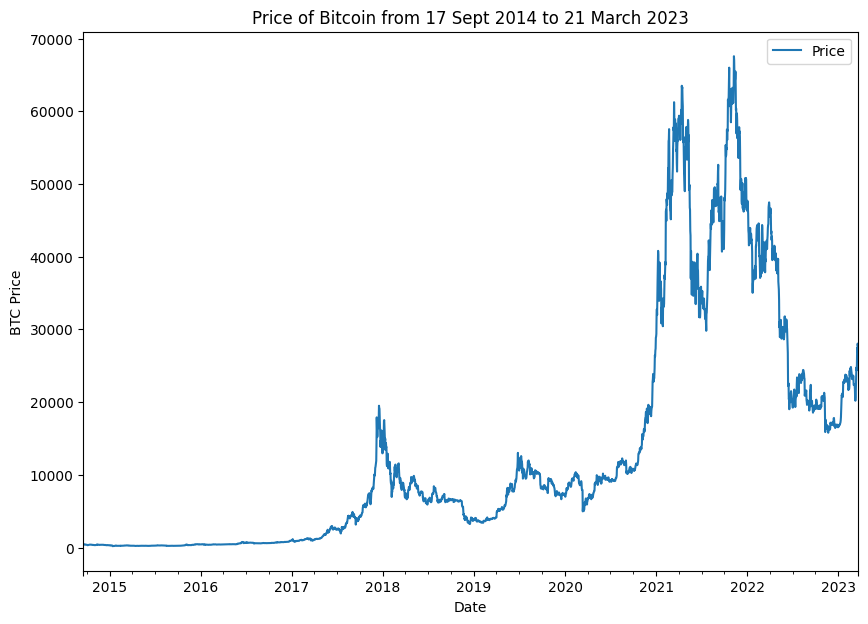

In [9]:
# let's plot everything
import matplotlib.pyplot as plt
bitcoin_prices.plot(figsize=(10, 7))
plt.ylabel("BTC Price")
plt.legend()
plt.title("Price of Bitcoin from 17 Sept 2014 to 21 March 2023");

### Importing time series data with Python's CSV module

In [10]:
import csv
from datetime import datetime

timesteps = []
btc_price = []

with open("/content/BTC-USD.csv", "r") as f:
  csv_reader = csv.reader(f, delimiter=",")
  next(csv_reader) # skip first line (this gets rid of the column titles)
  for line in csv_reader:
    timesteps.append(datetime.strptime(line[0], "%Y-%m-%d")) # get the dates as dates
    btc_price.append(float(line[5])) # get the adjusted closing price

# view first 10 of each
timesteps[:10], btc_price[:10]

([datetime.datetime(2014, 9, 17, 0, 0),
  datetime.datetime(2014, 9, 18, 0, 0),
  datetime.datetime(2014, 9, 19, 0, 0),
  datetime.datetime(2014, 9, 20, 0, 0),
  datetime.datetime(2014, 9, 21, 0, 0),
  datetime.datetime(2014, 9, 22, 0, 0),
  datetime.datetime(2014, 9, 23, 0, 0),
  datetime.datetime(2014, 9, 24, 0, 0),
  datetime.datetime(2014, 9, 25, 0, 0),
  datetime.datetime(2014, 9, 26, 0, 0)],
 [457.334015,
  424.440002,
  394.79599,
  408.903992,
  398.821014,
  402.152008,
  435.790985,
  423.204987,
  411.574005,
  404.424988])

Let's plot this

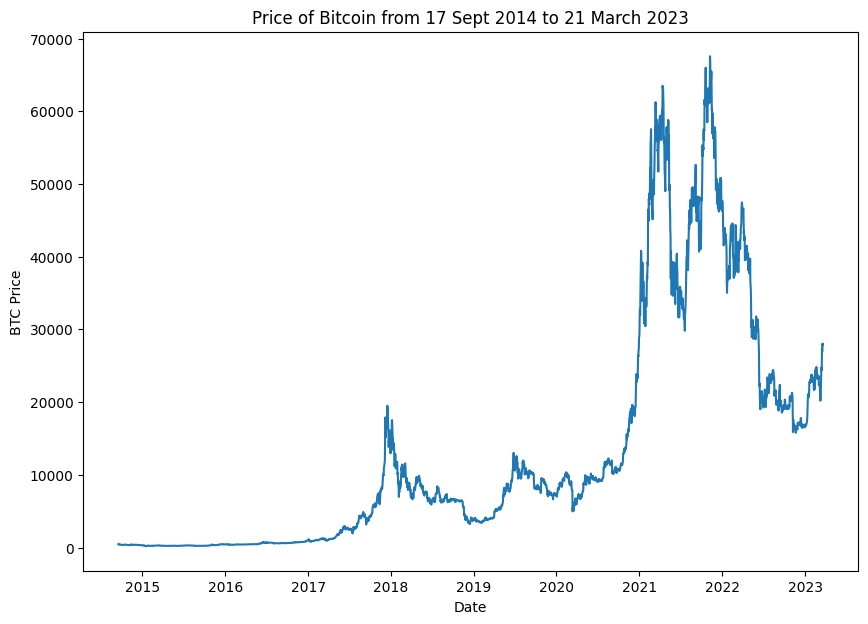

In [11]:
import matplotlib.pyplot as plt
import numpy as np
plt.figure(figsize=(10,7))
plt.plot(timesteps, btc_price)
plt.ylabel("BTC Price")
plt.xlabel("Date")
plt.title("Price of Bitcoin from 17 Sept 2014 to 21 March 2023");

## Format Data Part 1 : Create train and test sets for Time Series data

Before we create splits we want to know what kind of data we have.

In time series problems, you'll either have **univariate** and **multivariate** data.

- Univariate time series data deals with one variable, for example using the price of bitcoin to predict the price of bitcoin
- Multivariate time series data deals with more than one variable, for example predicting the price of bitcoin using the price of bitcoin and block rewards and volume

### Create Train and Test sets for time series (wrong way)


In [12]:
timesteps = bitcoin_prices.index.to_numpy()
prices = bitcoin_prices["Price"].to_numpy()

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(timesteps, prices, test_size=0.2, random_state=42)


X_train.shape, X_test.shape, y_train.shape, y_test.shape

((2486,), (622,), (2486,), (622,))

Looks like the splits worked well, but let's not trust numbers on a page, visualize, visualize and visualize

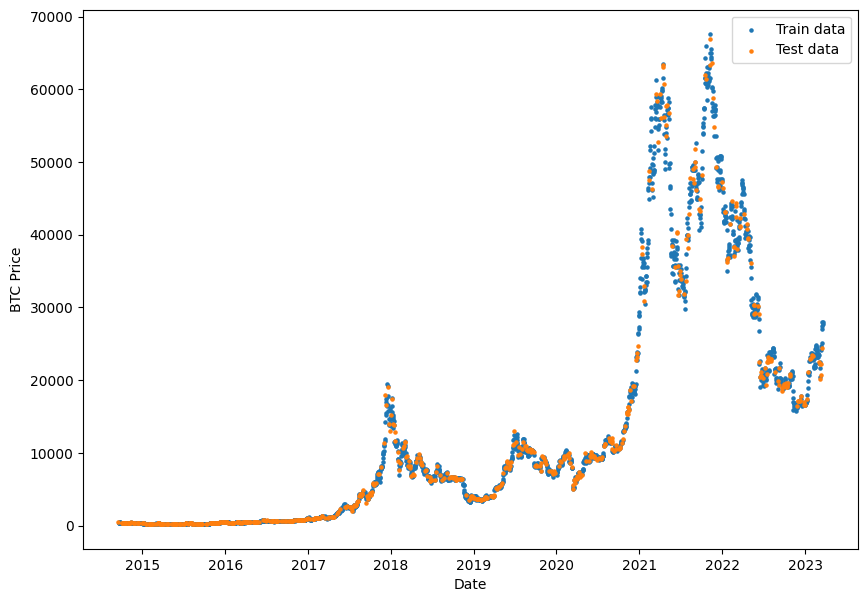

In [13]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,7))
plt.scatter(X_train, y_train, s=5, label="Train data")
plt.scatter(X_test, y_test, s=5, label="Test data")
plt.ylabel("BTC Price")
plt.xlabel("Date")
plt.legend();

Since this is a time component so the split should be continous, if there is no time component then random split will work but since we are going to forecast the future, then we need past data.

### Create Train and Test sets for time series (the right way)

In [14]:
split_size = int(0.8 * len(prices)) # 80% of train sets and 20% of test sets

X_train, y_train = timesteps[:split_size], prices[:split_size]
X_test, y_test = timesteps[split_size:], prices[split_size:]



Now if we visualize the plot,

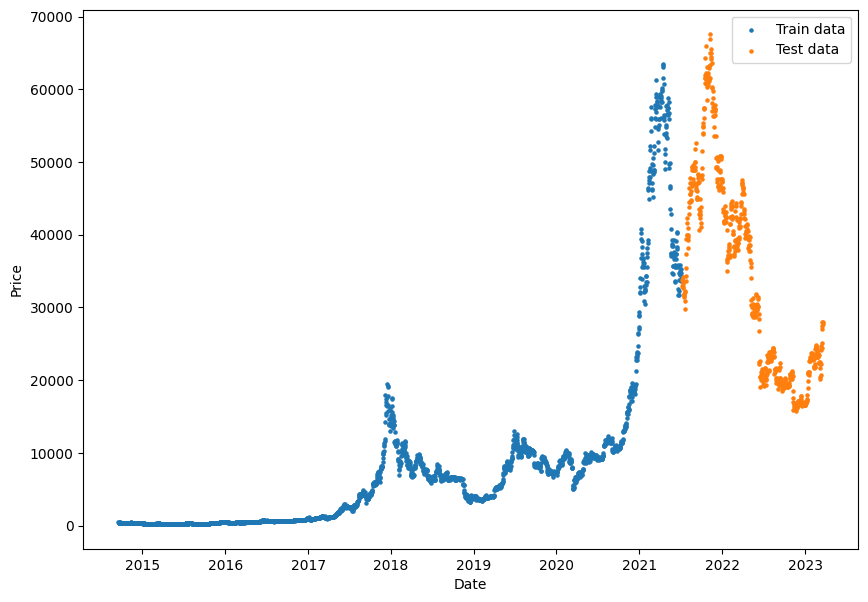

In [15]:
plt.figure(figsize=(10,7))
plt.scatter(X_train, y_train, s=5, label="Train data")
plt.scatter(X_test, y_test, s=5, label="Test data")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend();

This is the correct way of splitting the data of time series problem. The plot should look like above.

### Creating a plotting function

Rather than retyping `matplotlib` commands to continously plot data, let's make a plotting function we can reuse later

In [16]:
def plot_time_series(timesteps, values, format='.', start=0, end=None, label=None):
  """
  Plots a time series plot on timesteps (a series of points in time) against values
  (a series of values across timesteps)

  Parameters
  ------------
  timesteps: array of timesteps
  values: array of values across time
  format: style of plot, default '.'
  start: where to start the plot
  end: where to end the plot
  label: label to show on plot of values
  """
  # Plot the series
  plt.plot(timesteps[start:end], values[start:end], format, label=label)
  plt.xlabel("Time")
  plt.ylabel("BTC Price")
  if label:
    plt.legend(fontsize=14)
  plt.grid(True)

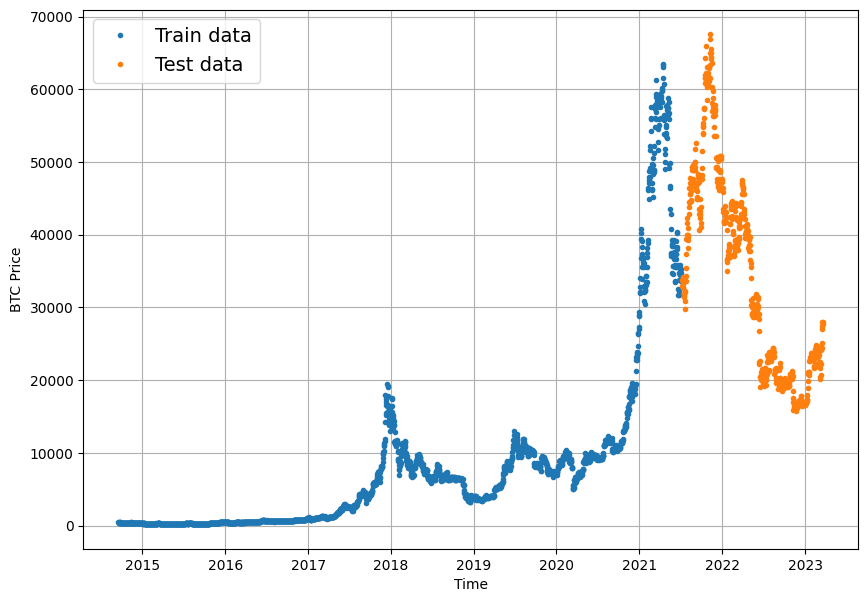

In [17]:
plt.figure(figsize=(10,7))
plot_time_series(X_train, y_train, label="Train data")
plot_time_series(X_test, y_test, label="Test data")

## Modelling Experiments

There are two terms that we should be familiar with, **horizon** and **window**,
- **horizon**: number of timesteps to predict into future
- **window**: number of timesteps from past used to predict **horizon**

For example, if we wanted to predict the price of Bitcoin for Tomorrow (1 day in the future) using the previous week's worth of Bitcoin prices (7 days in the past), the horizon would be 1 and window would be 7.


List of modelling experiments we are going to perform,


| **Model Number** | **Model Type** | **Horizon Size** | **Window Size** | **Extra data** |
|-------------|--------------|------------|------------|------------|
| 0 | Naive forecast (baseline) | NA | NA | NA |
| 1 | Dense model | 1 | 7 | NA |
| 2 | Same as 1 | 1 | 30 | NA |
| 3 | same as 1 | 7 | 30 | NA |
| 4 | Conv1D | 1 | 7 | NA |
| 5 | LSTM | 1 | 7 | NA |
| 6 | same as 1 (but with univariate) | 1 | 7 | Block reward size/Volume |
| 7 | [N-Beats Algorithm](https://arxiv.org/pdf/1905.10437.pdf) | 1 | 7 | NA |
| 8 | Ensemble (multiple models optimized on different loss functions) | 1 | 7 | NA |
| 9 | Future prediction model (model to predict future values) | 1 | 7 | NA |
| 10 | Same as 1 (but with turkey 🦃 data introduced) | 1 | 7 | NA |

## Model 0 : Naive forecast (baseline)

One of the most common baseline models for time series forecasting is naive model, (also called the naive forecast), requires no training at all.

That's because all the naive model does is use the previous timestep value to predict the next timestep value.

The formula looks like this:

$$\hat{y}_{t} = y_{t-1}$$

In English:

> The prediction at timestep `t`(y-hat) is equal to the value at timestep `t-1`(the previous timestep)

In an open system (like a stock market or crypto market), you'll often find beating the naive forecast with any kind of model is quite hard.

> 🔑 **Note**: an **open system** is a system where inputs and outputs can freely flow, such as market (stock or crypto), whereas a **closed system** the inputs and outputs are contained within the system (like a poker game with friends, as we know the buy in and how much the winner can get). Time series forecasting in **open systems** is generally quite poor.

In [18]:
# create a naive forecast
naive_forecast = y_test[:-1]

naive_forecast[:10], naive_forecast[-10:] # view first and last 10

(array([32877.371094, 33798.011719, 33520.519531, 34240.1875  ,
        33155.847656, 32702.025391, 32822.347656, 31780.730469,
        31421.539063, 31533.068359]),
 array([20632.410156, 22163.949219, 24197.533203, 24746.074219,
        24375.960938, 25052.789063, 27423.929688, 26965.878906,
        28038.675781, 27767.236328]))

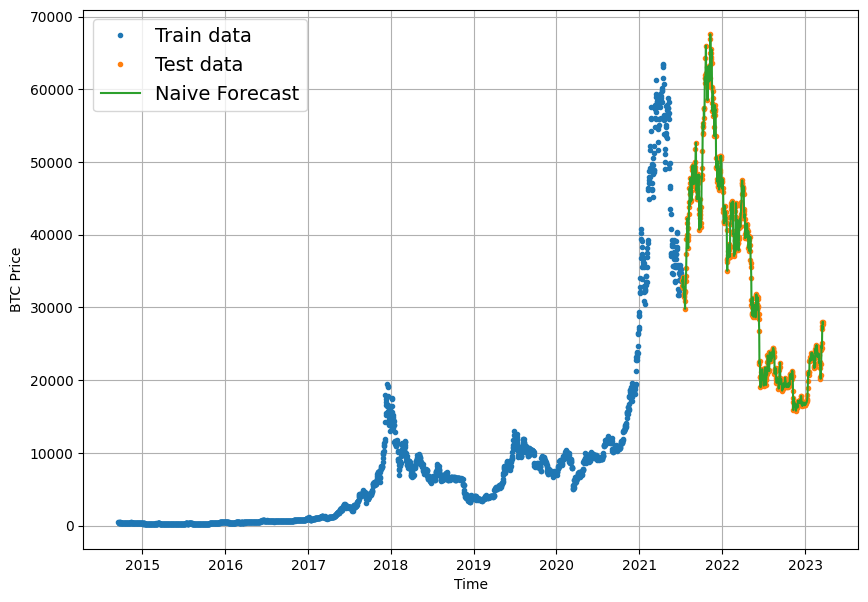

In [19]:
# plot the naive forecast
plt.figure(figsize=(10,7))
plot_time_series(timesteps=X_train, values=y_train, label="Train data")
plot_time_series(timesteps=X_test, values=y_test, label="Test data")
plot_time_series(timesteps=X_test[1:], values=naive_forecast, format="-", label="Naive Forecast");

Let's zoom it and only plot the test and naive forecast


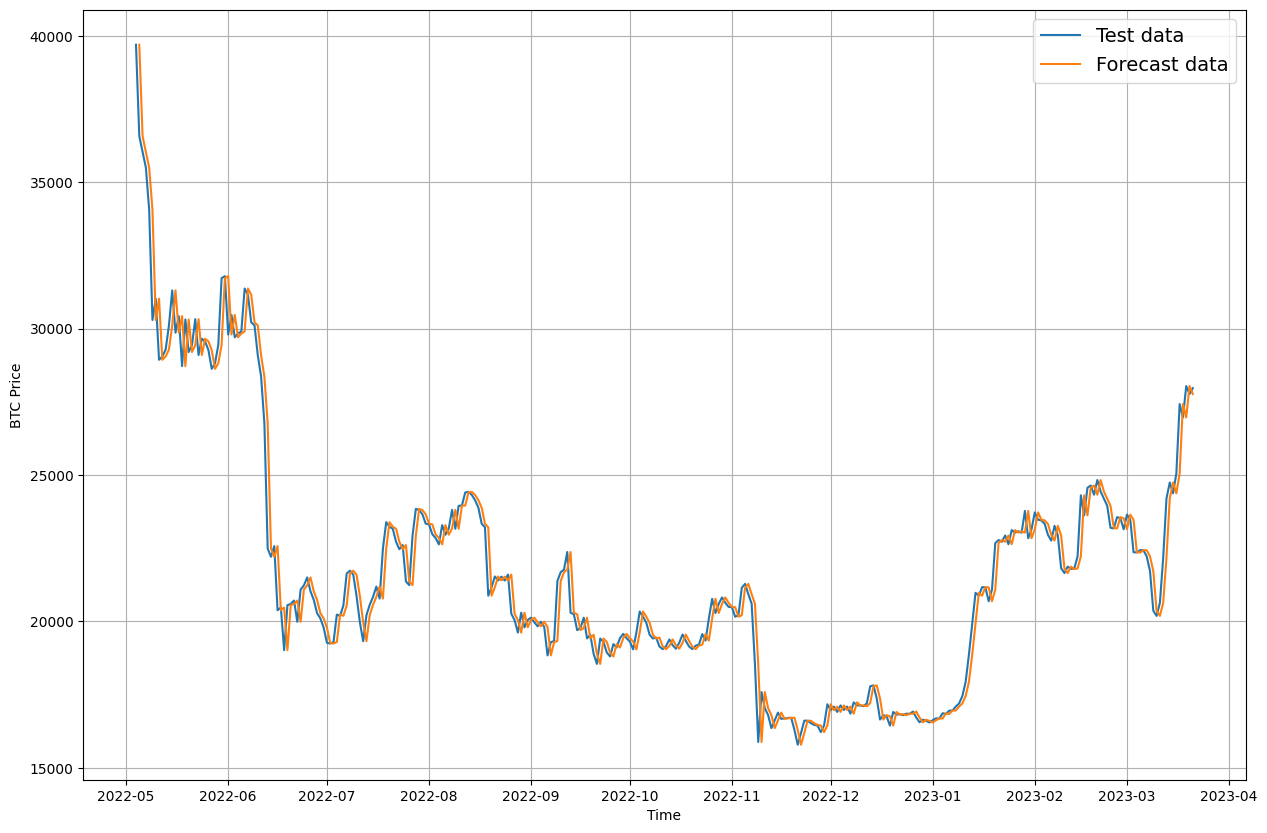

In [20]:
plt.figure(figsize=(15,10))
offset=300
plot_time_series(timesteps=X_test, values=y_test, start=offset, format="-", label="Test data")
plot_time_series(timesteps=X_test[1:], values=naive_forecast, start=offset, format="-", label="Forecast data");

When we zoom in we see the naive forecast comes slightly after the test data. This makes sense because the naive forecast uses the previous timestep value to predict the next timestep value.

Forecast made. Time to evaluate it.

## Evaluating a Time series model

Time series problem is often involves predicting a number which is the same output as Regression model, so we can similar types of metrics to evaluate Time series model, but let's see what are they, but thing to note for all the metrics, **lower the better** (for example an MAE of 0 is better than MAE 100).

### Scale Dependent Errors

These are metrics which can be used to compare time series values and forecasts which are in same scale.

for example, predicting the price of Bitcoin using historical prices in USD versus forecasting values in USD

| Metric | Details | Code |
| ------ |------ |------ |
| MAE (mean absolute error) |Easy to interpret (a forecast is X amount different from actual amount). Forecast methods which minimises the MAE will lead to forecasts of the median | `tf.keras.metrics.mean_absolute_error()` |
| RMSE (root mean squared error) | Forecasts which minimises the RMSE lead to forecasts of the mean | `tf.sqrt(tf.keras.metrics.mean_square_error())` |

### Percentage Errors

Percentage errors do not have units, this means they can be used to compare forecasts across different datasets.

| Metric | Details | Code |
| ---- | ---- | ---- |
| MAPE (mean absolute percentage error) | Most commonly used precentage error. May explode (not work) if `y=0` | `tf.keras.metrics.mean_absolute_percentage_error()` |
| sMAPE (symmetric mean absolute percentage error) | Recommended not to be used by [Forecasting: Principles and Practice](https://otexts.com/fpp3/accuracy.html#percentage-errors), though it is used in forecasting competitions | Custom implementation |


### Scaled Errors

Scaled errors are an alternative to percentage errors when comparing forecast performance across different time series.

| Metric | Details | Code |
| ---- | ---- | ---- |
| MASE (mean absolute scaled error) | MASE equals one of the naive forecast (or very close to one). A forecast which performs better than the naive should get < 1 MASE | See sktime's, [`mase_loss`](https://github.com/alan-turing-institute/sktime/blob/ee7a06843a44f4aaec7582d847e36073a9ab0566/sktime/performance_metrics/forecasting/_functions.py#L16) |


### Creating our own MASE function

We'll take inspiration from [sktime's](https://github.com/alan-turing-institute/sktime)(Scikit-Learn for time series) `MeanAbsoluteScaledError` class which calculates the MASE.
                                                                                                                          
                                                                                                                                                                                                                                                    


In [21]:
import tensorflow as tf

In [22]:
def mean_absolute_scaled_error(y_true, y_pred):
  """
  Implement MASE (assuming no seasonality of data).
  """
  mae = tf.reduce_mean(tf.abs(y_true, y_pred))

  naive_mae_no_seasonality = tf.reduce_mean(tf.abs(y_true[1:], y_true[:-1]))

  return mae / naive_mae_no_seasonality

Let's put each of our different evaluation metrics together into a function.

In [23]:
def evaluate_preds(y_true, y_pred):
  # Make sure float32 (for metric calculations)
  y_true = tf.cast(y_true, tf.float32)
  y_pred = tf.cast(y_pred, tf.float32)

  mae = tf.keras.metrics.mean_absolute_error(y_true, y_pred)
  mse = tf.keras.metrics.mean_squared_error(y_true, y_pred)
  rmse = tf.sqrt(mse)
  mape = tf.keras.metrics.mean_absolute_percentage_error(y_true, y_pred)
  mase = mean_absolute_scaled_error(y_true, y_pred)

  return {"mae": mae.numpy(),
          "mse": mse.numpy(),
          "rmse": rmse.numpy(),
          "mape": mape.numpy(),
          "mase": mase.numpy()}

In [24]:
naive_results = evaluate_preds(y_test[1:],
                               naive_forecast)

naive_results

{'mae': 807.27057,
 'mse': 1472736.0,
 'rmse': 1213.5634,
 'mape': 2.3311722,
 'mase': 1.0000142}

Alright, this will be our baseline results to beat in further modelling experiment.

So if we look into `mae` result, it's `807.27` it means that each prediction in the naive forecast is off by **$807**

## Other kinds of time series forecasting models which can be used for baselines and actual forecasts

| Model/Library Name |	Resource |
| ---- | ---- |
| Moving average |	https://machinelearningmastery.com/ moving-average-smoothing-for-time-series-forecasting-python/ |
| ARIMA (Autoregression Integrated Moving Average) |	https://machinelearningmastery.com/arima-for-time-series-forecasting-with-python/ |
| sktime (Scikit-Learn for time series) |	https://github.com/alan-turing-institute/sktime |
| TensorFlow Decision Forests (random forest, gradient boosting trees) |	https://www.tensorflow.org/decision_forests |
| Facebook Kats (purpose-built forecasting and time series analysis library by Facebook) |	https://github.com/facebookresearch/Kats |
| LinkedIn Greykite (flexible, intuitive and fast forecasts) |	https://github.com/linkedin/greykite |

## Format Data Part 2: Windowing dataset

We've got to window our time series.

Why do we window ?

Windowing is a method to turn a time series dataset into **supervised learning problem.**

In other words, we want to use windows of the past to predict the future.

For example, for a univariate time series, windowing for one week (window=7) to predict the next single value(horizon=1) might look like:

```
Window for one week (univariate time series)

[0, 1, 2, 3, 4, 5, 6] -> [7]
[1, 2, 3, 4, 5, 6, 7] -> [8]
[2, 3, 4, 5, 6, 7, 8] -> [9]
```

Similarly the price of Bitcoin look like,

```
Window for one week with the target of predicting the next day (Bitcoin prices)

[123.654, 125.455, 108.584, 118.674, 121.338, 120.655, 121.795] -> [123.033]
[125.455, 108.584, 118.674, 121.338, 120.655, 121.795, 123.033] -> [124.049]
[108.584, 118.674, 121.338, 120.655, 121.795, 123.033, 124.049] -> [125.961]
```

Let's build some functions which take in a univariate time series and turn it into windows and horizons of specified sizes.

We'll start with the default horizon size of 1 and a window size of 7 (these aren't necessarily the best values to use, these are just randomly picked)

In [25]:
HORIZON = 1
WINDOW_SIZE = 7

In [26]:
# Create a function which takes an array as input and return it in form of window and horizon
def get_labelled_windows(x, horizon=1):
  """
  Create labels for windowed dataset

  E.g if horizon=1 (default)
  Input: [1, 2, 3, 4, 5, 6, 7] -> Output: ([1, 2, 3, 4, 5, 6], [7])
  """
  return x[:, :-horizon], x[:, -horizon:]

In [27]:
# Test out the window labelling function
test_window, test_label = get_labelled_windows(tf.expand_dims(tf.range(8)+1, axis=0), horizon=HORIZON)

print(f"Window: {tf.squeeze(test_window).numpy()} -> Label: {tf.squeeze(test_label).numpy()}")

Window: [1 2 3 4 5 6 7] -> Label: 8


Now we can do the same thing with entire time series data through Python loops, but to make things faster we can use [Numpy's array indexing](https://numpy.org/doc/stable/reference/arrays.indexing.html).


Let's write a function which:

1. Creates a window step of specific window size, for example: `[[0, 1, 2, 3, 4, 5, 6, 7]]`
2. Uses Numpy indexing to create a 2D of multiple window steps, for example:

```
[0, 1, 2, 3, 4, 5, 6]
[1, 2, 3, 4, 5, 6, 7]
[2, 3, 4, 5, 6, 7, 8]
```
3. Uses the 2D array of multiple window steps to index on a target series.
4. Uses the `get_labelled_windows()` function we created above to turn the window steps into windows with a specified horizon.




In [28]:
def make_windows(x, window_size=7, horizon=1):
  """
  Turns a 1D array into a 2D array of sequential windows of window_size.
  """

  # 1. Create a window of specific window_size (add the horizon on the end for later labelling)
  window_step = np.expand_dims(np.arange(window_size+horizon), axis=0)
  #print(f"window_step: \n {window_step}")

  # 2. Create a 2D array of multiple window steps (minus 1 to account for 0 indexing)
  window_indexes = window_step + np.expand_dims(np.arange(len(x)-(window_size+horizon-1)), axis=0).T
  #print(f"Window indexes: \n {window_indexes[:3], window_indexes[-3:], window_indexes.shape}")

  # 3. Index on the target array (time series) with 2D array of multiple window steps
  windowed_array = x[window_indexes]

  # 4. Get the labelled windows
  windows, labels = get_labelled_windows(windowed_array, horizon=horizon)

  return windows, labels

Let's try with bitcoin prices

In [29]:
full_windows, full_labels = make_windows(prices, window_size=WINDOW_SIZE, horizon=HORIZON)
len(full_windows), len(full_labels)

(3101, 3101)

In [30]:
# View the first 3 windows/labels
for i in range(3):
  print(f"Window: {full_windows[i]} -> Label: {full_labels[i]} ")

Window: [457.334015 424.440002 394.79599  408.903992 398.821014 402.152008
 435.790985] -> Label: [423.204987] 
Window: [424.440002 394.79599  408.903992 398.821014 402.152008 435.790985
 423.204987] -> Label: [411.574005] 
Window: [394.79599  408.903992 398.821014 402.152008 435.790985 423.204987
 411.574005] -> Label: [404.424988] 


In [31]:
# View the last 3 windows/labels
for i in range(3):
  print(f"Window: {full_windows[i-3]} -> Label: {full_labels[i-3]} ")

Window: [22163.949219 24197.533203 24746.074219 24375.960938 25052.789063
 27423.929688 26965.878906] -> Label: [28038.675781] 
Window: [24197.533203 24746.074219 24375.960938 25052.789063 27423.929688
 26965.878906 28038.675781] -> Label: [27767.236328] 
Window: [24746.074219 24375.960938 25052.789063 27423.929688 26965.878906
 28038.675781 27767.236328] -> Label: [27964.888672] 


Anyways, we have written the whole function but this can also be achieved using [tf.keras.preprocessing.timeseries_dataset_from_array()](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/timeseries_dataset_from_array)

### Turning windows into Training and Test sets



In [32]:
# Make the train and test split
def make_train_test_split(windows, labels, test_split=0.2):

  split_size=int(len(windows) * (1-test_split)) # this will be default to 80% train/20% test
  train_windows = windows[:split_size]
  train_labels = labels[:split_size]
  test_windows = windows[split_size:]
  test_labels = labels[split_size:]

  return train_windows, test_windows, train_labels, test_labels

In [33]:
train_windows, test_windows, train_labels, test_labels = make_train_test_split(full_windows, full_labels)

len(train_windows), len(test_windows), len(train_labels), len(test_labels)

(2480, 621, 2480, 621)

In [34]:
train_windows[:5], train_labels[:5]

(array([[457.334015, 424.440002, 394.79599 , 408.903992, 398.821014,
         402.152008, 435.790985],
        [424.440002, 394.79599 , 408.903992, 398.821014, 402.152008,
         435.790985, 423.204987],
        [394.79599 , 408.903992, 398.821014, 402.152008, 435.790985,
         423.204987, 411.574005],
        [408.903992, 398.821014, 402.152008, 435.790985, 423.204987,
         411.574005, 404.424988],
        [398.821014, 402.152008, 435.790985, 423.204987, 411.574005,
         404.424988, 399.519989]]),
 array([[423.204987],
        [411.574005],
        [404.424988],
        [399.519989],
        [377.181   ]]))

## Creating a Model Checkpoint

For a fair comparison between all the models that we're going to build, we need to train it with equal amount of epochs let's say 100 and then store the best performing model during training so that we can compare with the best performing model.

This can be possible using `ModelCheckpoint`.

`ModelCheckpoint` callback will monitor our model's performance during training and save the best model to the file by setting `save_best_only=True`


In [35]:
import os

def create_model_checkpoint(model_name, save_path="model_experiments"):
  return tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join(save_path, model_name),
                                            monitor='val_loss',
                                            verbose=0,
                                            save_best_only=True)

## Model 1: Dense model (window=7, horizon=1)

We're going to start by keeping it simple, `model_1` will have:
- A single dense layer with 128 hidden units and reLu activation
- An output layer with linear activation
- Adam optimizer and MAE, MSE metrics
- Batch size of 128

In [36]:
import tensorflow as tf
from tensorflow.keras import layers

tf.random.set_seed(17)

# Construct model
model_1 = tf.keras.Sequential([
    layers.Dense(128, activation='relu'),
    layers.Dense(HORIZON, activation='linear')
], name='model_1_dense')


# compile the model
model_1.compile(loss='mae',
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['mae'])

# fit the model
model_1.fit(x=train_windows,
            y=train_labels,
            epochs=100,
            verbose=1,
            batch_size=128,
            validation_data=(test_windows, test_labels),
            callbacks=[create_model_checkpoint(model_name=model_1.name)])

Epoch 1/100
15/20 [=====================>........] - ETA: 0s - loss: 1765.2740 - mae: 1765.2740

20/20 [==============================] - 8s 163ms/step - loss: 1569.4240 - mae: 1569.4240 - val_loss: 1500.3351 - val_mae: 1500.3351
Epoch 2/100
17/20 [========================>.....] - ETA: 0s - loss: 520.5952 - mae: 520.5952

20/20 [==============================] - 2s 97ms/step - loss: 505.2159 - mae: 505.2159 - val_loss: 1331.0244 - val_mae: 1331.0244
Epoch 3/100
19/20 [===========================>..] - ETA: 0s - loss: 401.7064 - mae: 401.7064

20/20 [==============================] - 2s 105ms/step - loss: 405.5704 - mae: 405.5704 - val_loss: 1254.4039 - val_mae: 1254.4039
Epoch 4/100
11/20 [===============>..............] - ETA: 0s - loss: 406.4872 - mae: 406.4872

20/20 [==============================] - 2s 93ms/step - loss: 374.0729 - mae: 374.0729 - val_loss: 1215.0740 - val_mae: 1215.0740
Epoch 5/100
19/20 [===========================>..] - ETA: 0s - loss: 356.9844 - mae: 356.9844

20/20 [==============================] - 3s 183ms/step - loss: 358.5537 - mae: 358.5537 - val_loss: 1125.3558 - val_mae: 1125.3558
Epoch 6/100
20/20 [==============================] - 0s 15ms/step - loss: 347.7998 - mae: 347.7998 - val_loss: 1167.7336 - val_mae: 1167.7336
Epoch 7/100
18/20 [==========================>...] - ETA: 0s - loss: 348.1098 - mae: 348.1098

20/20 [==============================] - 1s 68ms/step - loss: 347.5786 - mae: 347.5786 - val_loss: 1076.6362 - val_mae: 1076.6362
Epoch 8/100
20/20 [==============================] - 0s 3ms/step - loss: 349.7617 - mae: 349.7617 - val_loss: 1287.5217 - val_mae: 1287.5217
Epoch 9/100
 1/20 [>.............................] - ETA: 0s - loss: 363.1959 - mae: 363.1959

20/20 [==============================] - 1s 55ms/step - loss: 349.8360 - mae: 349.8360 - val_loss: 1010.0308 - val_mae: 1010.0308
Epoch 10/100
20/20 [==============================] - 0s 10ms/step - loss: 312.0128 - mae: 312.0128 - val_loss: 1061.8105 - val_mae: 1061.8105
Epoch 11/100
20/20 [==============================] - 0s 14ms/step - loss: 314.1850 - mae: 314.1850 - val_loss: 1092.5618 - val_mae: 1092.5618
Epoch 12/100
19/20 [===========================>..] - ETA: 0s - loss: 306.6224 - mae: 306.6224

20/20 [==============================] - 1s 68ms/step - loss: 305.7160 - mae: 305.7160 - val_loss: 990.8994 - val_mae: 990.8994
Epoch 13/100
20/20 [==============================] - 0s 11ms/step - loss: 296.5078 - mae: 296.5078 - val_loss: 1026.9736 - val_mae: 1026.9736
Epoch 14/100
20/20 [==============================] - 0s 6ms/step - loss: 286.1620 - mae: 286.1620 - val_loss: 1059.2815 - val_mae: 1059.2815
Epoch 15/100
20/20 [==============================] - 0s 4ms/step - loss: 291.8387 - mae: 291.8387 - val_loss: 999.0678 - val_mae: 999.0678
Epoch 16/100
20/20 [==============================] - 0s 7ms/step - loss: 288.7121 - mae: 288.7121 - val_loss: 1011.9719 - val_mae: 1011.9719
Epoch 17/100
20/20 [==============================] - 0s 10ms/step - loss: 291.8879 - mae: 291.8879 - val_loss: 1109.1208 - val_mae: 1109.1208
Epoch 18/100
20/20 [==============================] - 0s 5ms/step - loss: 282.5414 - mae: 282.5414 - val_loss: 1219.5959 - val_mae: 1219.5959
Epoch 19/100
19/20 [

20/20 [==============================] - 1s 62ms/step - loss: 295.2007 - mae: 295.2007 - val_loss: 962.2120 - val_mae: 962.2120
Epoch 20/100
20/20 [==============================] - 0s 11ms/step - loss: 287.8359 - mae: 287.8359 - val_loss: 975.7952 - val_mae: 975.7952
Epoch 21/100
20/20 [==============================] - ETA: 0s - loss: 281.7097 - mae: 281.7097

20/20 [==============================] - 1s 50ms/step - loss: 281.7097 - mae: 281.7097 - val_loss: 899.3192 - val_mae: 899.3192
Epoch 22/100
 1/20 [>.............................] - ETA: 0s - loss: 232.5339 - mae: 232.5339

20/20 [==============================] - 1s 40ms/step - loss: 278.8082 - mae: 278.8082 - val_loss: 891.2646 - val_mae: 891.2646
Epoch 23/100
20/20 [==============================] - 0s 4ms/step - loss: 271.0650 - mae: 271.0650 - val_loss: 1006.1200 - val_mae: 1006.1200
Epoch 24/100
20/20 [==============================] - 0s 6ms/step - loss: 278.5010 - mae: 278.5010 - val_loss: 908.2346 - val_mae: 908.2346
Epoch 25/100
20/20 [==============================] - 0s 9ms/step - loss: 279.3327 - mae: 279.3327 - val_loss: 936.9173 - val_mae: 936.9173
Epoch 26/100
20/20 [==============================] - 0s 7ms/step - loss: 277.6765 - mae: 277.6765 - val_loss: 940.9225 - val_mae: 940.9225
Epoch 27/100
20/20 [==============================] - 0s 7ms/step - loss: 286.3568 - mae: 286.3568 - val_loss: 1021.8228 - val_mae: 1021.8228
Epoch 28/100
16/20 [=======================>......] - ETA: 0s - loss: 278.5871 - mae: 278.5871

20/20 [==============================] - 1s 59ms/step - loss: 272.0011 - mae: 272.0011 - val_loss: 880.3373 - val_mae: 880.3373
Epoch 29/100
20/20 [==============================] - 0s 10ms/step - loss: 262.4594 - mae: 262.4594 - val_loss: 884.5426 - val_mae: 884.5426
Epoch 30/100
20/20 [==============================] - 0s 9ms/step - loss: 271.8885 - mae: 271.8885 - val_loss: 967.3159 - val_mae: 967.3159
Epoch 31/100
20/20 [==============================] - 0s 8ms/step - loss: 268.0173 - mae: 268.0173 - val_loss: 906.5386 - val_mae: 906.5386
Epoch 32/100
20/20 [==============================] - 0s 9ms/step - loss: 264.0228 - mae: 264.0228 - val_loss: 898.6190 - val_mae: 898.6190
Epoch 33/100
19/20 [===========================>..] - ETA: 0s - loss: 269.0882 - mae: 269.0882

20/20 [==============================] - 1s 64ms/step - loss: 272.7155 - mae: 272.7155 - val_loss: 863.4724 - val_mae: 863.4724
Epoch 34/100
 1/20 [>.............................] - ETA: 0s - loss: 218.5338 - mae: 218.5338

20/20 [==============================] - 1s 35ms/step - loss: 262.5823 - mae: 262.5823 - val_loss: 861.0881 - val_mae: 861.0881
Epoch 35/100
20/20 [==============================] - 0s 4ms/step - loss: 273.6881 - mae: 273.6881 - val_loss: 940.8088 - val_mae: 940.8088
Epoch 36/100
 1/20 [>.............................] - ETA: 0s - loss: 261.3558 - mae: 261.3558

20/20 [==============================] - 1s 69ms/step - loss: 273.6235 - mae: 273.6235 - val_loss: 860.7056 - val_mae: 860.7056
Epoch 37/100
20/20 [==============================] - 0s 4ms/step - loss: 269.2304 - mae: 269.2304 - val_loss: 872.4551 - val_mae: 872.4551
Epoch 38/100
20/20 [==============================] - 0s 4ms/step - loss: 265.3320 - mae: 265.3320 - val_loss: 941.3880 - val_mae: 941.3880
Epoch 39/100
 1/20 [>.............................] - ETA: 0s - loss: 343.9430 - mae: 343.9430

20/20 [==============================] - 1s 48ms/step - loss: 277.4066 - mae: 277.4066 - val_loss: 853.6050 - val_mae: 853.6050
Epoch 40/100
20/20 [==============================] - 0s 8ms/step - loss: 290.9424 - mae: 290.9424 - val_loss: 1142.1766 - val_mae: 1142.1766
Epoch 41/100
20/20 [==============================] - 0s 6ms/step - loss: 296.2025 - mae: 296.2025 - val_loss: 926.1699 - val_mae: 926.1699
Epoch 42/100
18/20 [==========================>...] - ETA: 0s - loss: 273.0323 - mae: 273.0323

20/20 [==============================] - 1s 45ms/step - loss: 274.1119 - mae: 274.1119 - val_loss: 849.1879 - val_mae: 849.1879
Epoch 43/100
20/20 [==============================] - 0s 8ms/step - loss: 259.9998 - mae: 259.9998 - val_loss: 874.5529 - val_mae: 874.5529
Epoch 44/100
20/20 [==============================] - 0s 4ms/step - loss: 260.7407 - mae: 260.7407 - val_loss: 917.7286 - val_mae: 917.7286
Epoch 45/100
20/20 [==============================] - 0s 3ms/step - loss: 271.4483 - mae: 271.4483 - val_loss: 852.1707 - val_mae: 852.1707
Epoch 46/100
 1/20 [>.............................] - ETA: 0s - loss: 226.4974 - mae: 226.4974

20/20 [==============================] - 1s 59ms/step - loss: 267.1166 - mae: 267.1166 - val_loss: 844.1964 - val_mae: 844.1964
Epoch 47/100
19/20 [===========================>..] - ETA: 0s - loss: 257.2707 - mae: 257.2707

20/20 [==============================] - 1s 52ms/step - loss: 253.9967 - mae: 253.9967 - val_loss: 842.1292 - val_mae: 842.1292
Epoch 48/100
20/20 [==============================] - 0s 9ms/step - loss: 255.9032 - mae: 255.9032 - val_loss: 844.4454 - val_mae: 844.4454
Epoch 49/100
17/20 [========================>.....] - ETA: 0s - loss: 257.0216 - mae: 257.0216

20/20 [==============================] - 1s 44ms/step - loss: 261.2812 - mae: 261.2812 - val_loss: 839.8297 - val_mae: 839.8297
Epoch 50/100
20/20 [==============================] - 0s 6ms/step - loss: 254.3848 - mae: 254.3848 - val_loss: 858.3624 - val_mae: 858.3624
Epoch 51/100
20/20 [==============================] - 0s 5ms/step - loss: 257.9823 - mae: 257.9823 - val_loss: 928.4975 - val_mae: 928.4975
Epoch 52/100
20/20 [==============================] - 0s 7ms/step - loss: 254.6479 - mae: 254.6479 - val_loss: 874.8928 - val_mae: 874.8928
Epoch 53/100
 1/20 [>.............................] - ETA: 0s - loss: 278.3076 - mae: 278.3076

20/20 [==============================] - 1s 67ms/step - loss: 254.3171 - mae: 254.3171 - val_loss: 838.1011 - val_mae: 838.1011
Epoch 54/100
20/20 [==============================] - 0s 14ms/step - loss: 255.5518 - mae: 255.5518 - val_loss: 838.8525 - val_mae: 838.8525
Epoch 55/100
20/20 [==============================] - 0s 14ms/step - loss: 261.3848 - mae: 261.3848 - val_loss: 896.9548 - val_mae: 896.9548
Epoch 56/100
20/20 [==============================] - 0s 6ms/step - loss: 261.0795 - mae: 261.0795 - val_loss: 866.2210 - val_mae: 866.2210
Epoch 57/100
 1/20 [>.............................] - ETA: 0s - loss: 251.0190 - mae: 251.0190

20/20 [==============================] - 1s 37ms/step - loss: 258.4846 - mae: 258.4846 - val_loss: 832.9539 - val_mae: 832.9539
Epoch 58/100
20/20 [==============================] - 0s 5ms/step - loss: 261.6025 - mae: 261.6025 - val_loss: 909.1177 - val_mae: 909.1177
Epoch 59/100
20/20 [==============================] - 0s 6ms/step - loss: 251.9025 - mae: 251.9025 - val_loss: 838.1245 - val_mae: 838.1245
Epoch 60/100
20/20 [==============================] - 0s 5ms/step - loss: 256.1415 - mae: 256.1415 - val_loss: 844.4265 - val_mae: 844.4265
Epoch 61/100
20/20 [==============================] - 0s 5ms/step - loss: 255.1019 - mae: 255.1019 - val_loss: 884.7156 - val_mae: 884.7156
Epoch 62/100
20/20 [==============================] - 0s 5ms/step - loss: 258.9505 - mae: 258.9505 - val_loss: 971.2191 - val_mae: 971.2191
Epoch 63/100
20/20 [==============================] - 0s 5ms/step - loss: 267.7968 - mae: 267.7968 - val_loss: 885.4087 - val_mae: 885.4087
Epoch 64/100
20/20 [============

20/20 [==============================] - 1s 39ms/step - loss: 259.6531 - mae: 259.6531 - val_loss: 832.0394 - val_mae: 832.0394
Epoch 65/100
20/20 [==============================] - 0s 4ms/step - loss: 265.8395 - mae: 265.8395 - val_loss: 858.1635 - val_mae: 858.1635
Epoch 66/100
20/20 [==============================] - 0s 4ms/step - loss: 257.2273 - mae: 257.2273 - val_loss: 834.7494 - val_mae: 834.7494
Epoch 67/100
20/20 [==============================] - 0s 4ms/step - loss: 275.7831 - mae: 275.7831 - val_loss: 954.9529 - val_mae: 954.9529
Epoch 68/100
 1/20 [>.............................] - ETA: 0s - loss: 212.8414 - mae: 212.8414

20/20 [==============================] - 1s 26ms/step - loss: 256.0666 - mae: 256.0666 - val_loss: 827.2992 - val_mae: 827.2992
Epoch 69/100
20/20 [==============================] - 0s 4ms/step - loss: 249.5373 - mae: 249.5373 - val_loss: 1065.1244 - val_mae: 1065.1244
Epoch 70/100
20/20 [==============================] - 0s 4ms/step - loss: 266.7572 - mae: 266.7572 - val_loss: 850.7828 - val_mae: 850.7828
Epoch 71/100
20/20 [==============================] - 0s 4ms/step - loss: 251.1945 - mae: 251.1945 - val_loss: 830.0023 - val_mae: 830.0023
Epoch 72/100
20/20 [==============================] - 0s 4ms/step - loss: 251.1492 - mae: 251.1492 - val_loss: 1094.6919 - val_mae: 1094.6919
Epoch 73/100
20/20 [==============================] - 0s 4ms/step - loss: 277.0844 - mae: 277.0844 - val_loss: 1073.1813 - val_mae: 1073.1812
Epoch 74/100
20/20 [==============================] - 0s 5ms/step - loss: 249.6684 - mae: 249.6684 - val_loss: 876.1596 - val_mae: 876.1596
Epoch 75/100
20/20 [======

20/20 [==============================] - 0s 25ms/step - loss: 254.6819 - mae: 254.6819 - val_loss: 826.3608 - val_mae: 826.3608
Epoch 77/100
20/20 [==============================] - 0s 3ms/step - loss: 262.2516 - mae: 262.2516 - val_loss: 830.4286 - val_mae: 830.4286
Epoch 78/100
20/20 [==============================] - 0s 3ms/step - loss: 260.9088 - mae: 260.9088 - val_loss: 968.1151 - val_mae: 968.1151
Epoch 79/100
20/20 [==============================] - 0s 4ms/step - loss: 265.3503 - mae: 265.3503 - val_loss: 832.6974 - val_mae: 832.6974
Epoch 80/100
20/20 [==============================] - 0s 5ms/step - loss: 267.2880 - mae: 267.2880 - val_loss: 902.8339 - val_mae: 902.8339
Epoch 81/100
20/20 [==============================] - 0s 4ms/step - loss: 257.7273 - mae: 257.7273 - val_loss: 841.0350 - val_mae: 841.0350
Epoch 82/100
20/20 [==============================] - 0s 3ms/step - loss: 272.0331 - mae: 272.0331 - val_loss: 1416.2776 - val_mae: 1416.2776
Epoch 83/100
20/20 [==========

20/20 [==============================] - 1s 28ms/step - loss: 262.0658 - mae: 262.0658 - val_loss: 821.6551 - val_mae: 821.6551
Epoch 88/100
20/20 [==============================] - 0s 4ms/step - loss: 252.8231 - mae: 252.8231 - val_loss: 831.8574 - val_mae: 831.8574
Epoch 89/100
20/20 [==============================] - 0s 4ms/step - loss: 255.9992 - mae: 255.9992 - val_loss: 824.3832 - val_mae: 824.3832
Epoch 90/100
20/20 [==============================] - 0s 3ms/step - loss: 251.0198 - mae: 251.0198 - val_loss: 1055.1964 - val_mae: 1055.1964
Epoch 91/100
20/20 [==============================] - 0s 3ms/step - loss: 257.3740 - mae: 257.3740 - val_loss: 827.6125 - val_mae: 827.6125
Epoch 92/100
20/20 [==============================] - 0s 4ms/step - loss: 253.2227 - mae: 253.2227 - val_loss: 838.8757 - val_mae: 838.8757
Epoch 93/100
20/20 [==============================] - 0s 3ms/step - loss: 252.4898 - mae: 252.4898 - val_loss: 826.0222 - val_mae: 826.0222
Epoch 94/100
20/20 [==========

In [37]:
# evaluate the model
model_1.evaluate(test_windows, test_labels)

20/20 [==============================] - 0s 2ms/step - loss: 889.4296 - mae: 889.4296


[889.4296264648438, 889.4296264648438]

This is the last epoch's evaluation results, but let's check the best model weights

In [38]:
model_1 = tf.keras.models.load_model('model_experiments/model_1_dense')
model_1.evaluate(test_windows, test_labels)

20/20 [==============================] - 0s 2ms/step - loss: 821.6549 - mae: 821.6549


[821.6549072265625, 821.6549072265625]

Okay, not bad but what about the predictions on `model_1`. Let's create a function to make predictions and then evaluate the results of model_1 on those predictions.

### Make Prediction function

In [39]:
def make_predictions(model, input_data):
  """
  Returns the prediction result on input_data for the model passed.
  """
  y_preds = model.predict(input_data)
  return tf.squeeze(y_preds) # returns 1D array of predictions

In [40]:
model_1_preds = make_predictions(model_1, test_windows)
model_1_preds[:10]

20/20 [==============================] - 0s 1ms/step


<tf.Tensor: shape=(10,), dtype=float32, numpy=
array([32974.94 , 33515.066, 33569.934, 34113.66 , 33295.387, 32730.297,
       32700.8  , 31892.871, 31328.527, 31410.182], dtype=float32)>

In [41]:
test_labels.shape, model_1_preds.shape

((621, 1), TensorShape([621]))

In [42]:
# evaluate results
model_1_results = evaluate_preds(y_true=tf.squeeze(test_labels), y_pred=model_1_preds)
model_1_results

{'mae': 821.655,
 'mse': 1530718.4,
 'rmse': 1237.222,
 'mape': 2.3750055,
 'mase': 1.0000142}

In [43]:
# view the naive results
naive_results

{'mae': 807.27057,
 'mse': 1472736.0,
 'rmse': 1213.5634,
 'mape': 2.3311722,
 'mase': 1.0000142}

Naive model results (baseline) is beating our first dense model(model_1) but that's expected. Let's do further visualization by plotting the prediction in the graph.

### Plot `model_1` results

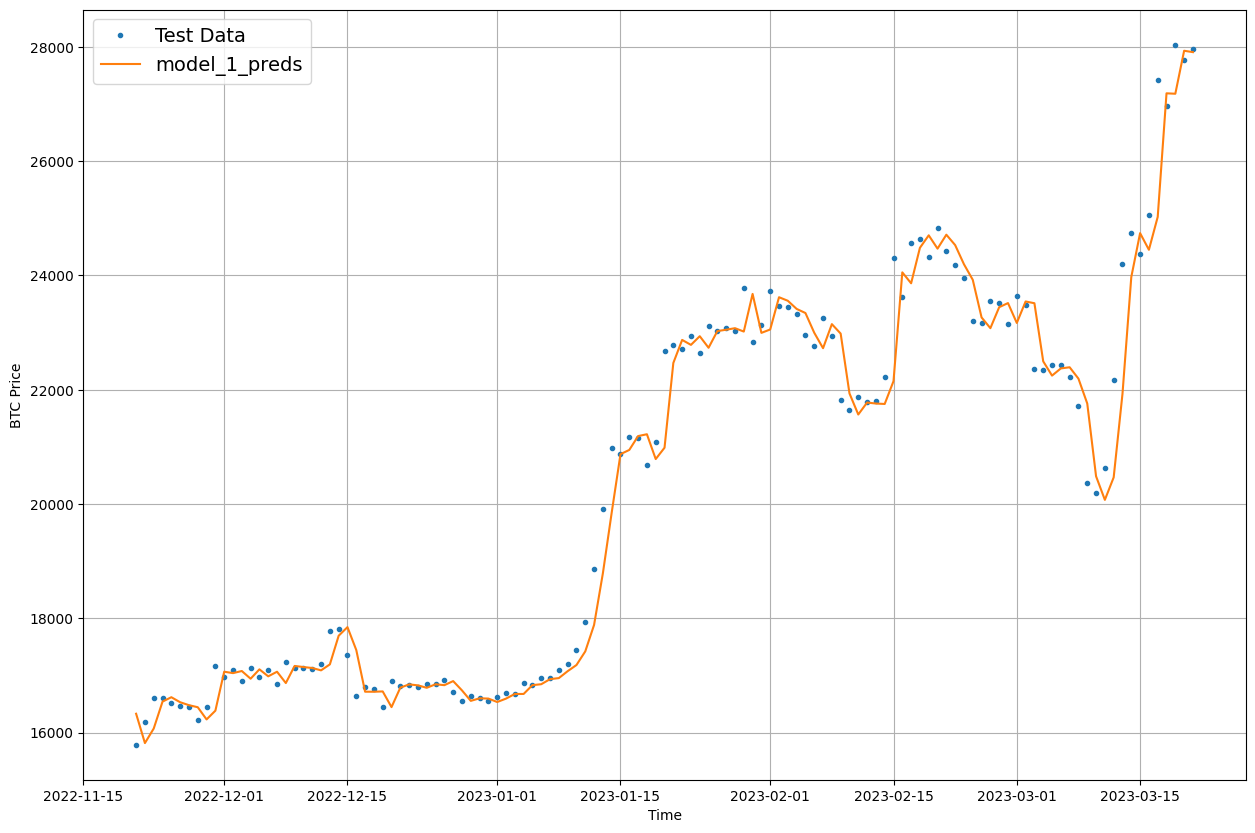

In [44]:
offset = 500
plt.figure(figsize=(15, 10))
plot_time_series(timesteps=X_test[-len(test_windows):],values=test_labels[:, 0], start=offset, label="Test Data")
plot_time_series(timesteps=X_test[-len(test_windows):], values=model_1_preds, start=offset, format="-",label="model_1_preds")

Something wrong with the predictions ? 

And also predictions are little behind the actual values. For more about this, [Read Autocorrelation](https://otexts.com/fpp3/acf.html)

Since they're on the test dataset. So they're not actual forecasts that we are trying for predicting a price.

With our current model setup, we've to make forecasts for the future.

## Model 2: Dense (window=30, horizon=1)

In this model we are going to predict on window_size 30, that is past 30 days of bitcoin prices to predict next day of bitcoin price.

In [45]:
HORIZON=1
WINDOW_SIZE=30

In [46]:
# Reset the windows and labels with 30 day prices of bitcoin
full_windows, full_labels = make_windows(prices, window_size=WINDOW_SIZE, horizon=HORIZON)
full_windows[:2], full_labels[:2]

(array([[457.334015, 424.440002, 394.79599 , 408.903992, 398.821014,
         402.152008, 435.790985, 423.204987, 411.574005, 404.424988,
         399.519989, 377.181   , 375.46701 , 386.944   , 383.61499 ,
         375.071991, 359.511993, 328.865997, 320.51001 , 330.07901 ,
         336.187012, 352.940002, 365.026001, 361.562012, 362.299011,
         378.549011, 390.414001, 400.869995, 394.77301 , 382.556   ],
        [424.440002, 394.79599 , 408.903992, 398.821014, 402.152008,
         435.790985, 423.204987, 411.574005, 404.424988, 399.519989,
         377.181   , 375.46701 , 386.944   , 383.61499 , 375.071991,
         359.511993, 328.865997, 320.51001 , 330.07901 , 336.187012,
         352.940002, 365.026001, 361.562012, 362.299011, 378.549011,
         390.414001, 400.869995, 394.77301 , 382.556   , 383.757996]]),
 array([[383.757996],
        [391.441986]]))

In [47]:
# Create train and test split
train_windows, test_windows, train_labels, test_labels = make_train_test_split(full_windows, full_labels)

len(train_windows), len(test_windows), len(train_labels), len(test_labels)

(2462, 616, 2462, 616)

In [48]:
# Now ready to create our dense model

tf.random.set_seed(17)

# Create the model
model_2 = tf.keras.Sequential([
    layers.Dense(128, activation='relu'),
    layers.Dense(HORIZON, activation='linear')
], 'model_2_dense')

# compile the model
model_2.compile(loss='mae',
                optimizer=tf.keras.optimizers.Adam())

# Fit the model
model_2.fit(train_windows,
            train_labels,
            batch_size=128,
            epochs=100,
            verbose=0,
            validation_data=(test_windows, test_labels),
            callbacks=[create_model_checkpoint(model_name=model_2.name)])

In [49]:
# evaluate the model with the last epochs 
model_2.evaluate(test_windows, test_labels)

20/20 [==============================] - 0s 1ms/step - loss: 953.9434


953.943359375

In [50]:
# Evaluation on the best model
model_2 = tf.keras.models.load_model('model_experiments/model_2_dense/')
model_2.evaluate(test_windows, test_labels)

20/20 [==============================] - 0s 1ms/step - loss: 866.2175


866.217529296875

In [51]:
# prediction on model_2
model_2_preds = make_predictions(model_2, test_windows)

# evaluate the results
model_2_results = evaluate_preds(tf.squeeze(test_labels), model_2_preds)
model_2_results

20/20 [==============================] - 0s 1ms/step


{'mae': 866.2174,
 'mse': 1667330.8,
 'rmse': 1291.2516,
 'mape': 2.4956543,
 'mase': 0.99996686}

In [52]:
model_1_results

{'mae': 821.655,
 'mse': 1530718.4,
 'rmse': 1237.222,
 'mape': 2.3750055,
 'mase': 1.0000142}

It looks like `model_1` performs better than `model_2`.

Also, smaller windows size is performing better so in that case we can create window size of something like 5 days.



How do the predictions look ?

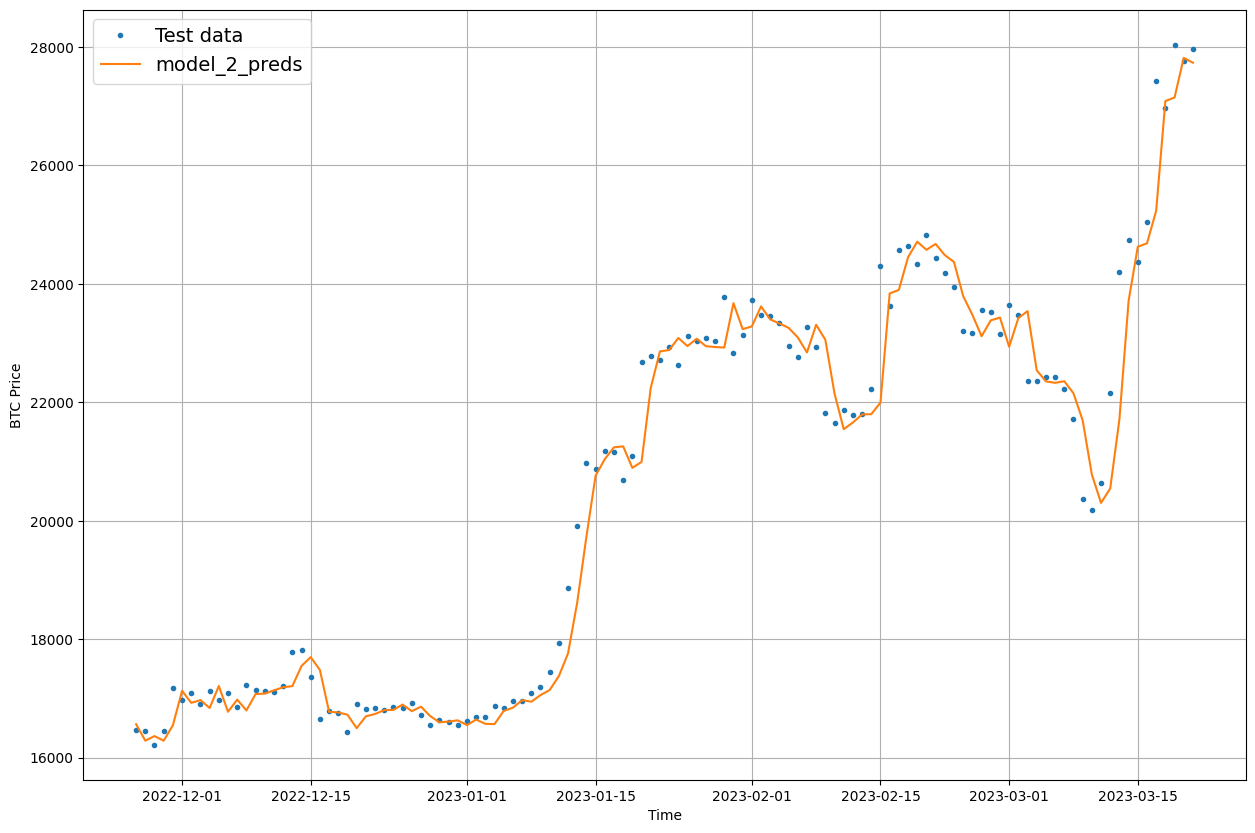

In [53]:
offset = 500
plt.figure(figsize=(15,10))

plot_time_series(timesteps=X_test[-len(test_windows):], values=test_labels[:,0], start=offset, label="Test data")
plot_time_series(timesteps=X_test[-len(test_windows):], values=model_2_preds, start=offset, format="-", label="model_2_preds")

## Model 3 : Dense(window=30, horizon=7)

In [54]:
HORIZON=7
WINDOW_SIZE=30

# create windows and labels
full_windows, full_labels = make_windows(prices, window_size=WINDOW_SIZE, horizon=HORIZON)

# Make train and test split
train_windows, test_windows, train_labels, test_labels = make_train_test_split(full_windows, full_labels)

train_windows[:2], train_labels[:2]

(array([[457.334015, 424.440002, 394.79599 , 408.903992, 398.821014,
         402.152008, 435.790985, 423.204987, 411.574005, 404.424988,
         399.519989, 377.181   , 375.46701 , 386.944   , 383.61499 ,
         375.071991, 359.511993, 328.865997, 320.51001 , 330.07901 ,
         336.187012, 352.940002, 365.026001, 361.562012, 362.299011,
         378.549011, 390.414001, 400.869995, 394.77301 , 382.556   ],
        [424.440002, 394.79599 , 408.903992, 398.821014, 402.152008,
         435.790985, 423.204987, 411.574005, 404.424988, 399.519989,
         377.181   , 375.46701 , 386.944   , 383.61499 , 375.071991,
         359.511993, 328.865997, 320.51001 , 330.07901 , 336.187012,
         352.940002, 365.026001, 361.562012, 362.299011, 378.549011,
         390.414001, 400.869995, 394.77301 , 382.556   , 383.757996]]),
 array([[383.757996, 391.441986, 389.54599 , 382.845001, 386.475006,
         383.15799 , 358.416992],
        [391.441986, 389.54599 , 382.845001, 386.475006, 383.1579

In [55]:
len(train_windows), len(test_windows)

(2457, 615)

In [56]:
tf.random.set_seed(17)

# Create Model
model_3 = tf.keras.Sequential([
    layers.Dense(128, activation='relu'),
    layers.Dense(HORIZON)
], name='model_3_dense')

# Compile
model_3.compile(loss='mae',
                optimizer=tf.keras.optimizers.Adam())

# Fit 
model_3.fit(train_windows,
            train_labels,
            epochs=100,
            batch_size=128,
            verbose=0,
            validation_data=(test_windows, test_labels),
            callbacks=[create_model_checkpoint(model_name=model_3.name)])

In [57]:
# evaluation on last epoch
model_3.evaluate(test_windows, test_labels)

20/20 [==============================] - 0s 2ms/step - loss: 1743.1130


1743.113037109375

In [58]:
# load the best model and evaluate
model_3 = tf.keras.models.load_model('model_experiments/model_3_dense/')
model_3.evaluate(test_windows, test_labels)

20/20 [==============================] - 0s 2ms/step - loss: 1726.9423


1726.9422607421875

This is going to be large because we are trying to predict 7 days in advance, for example we want to predict the weather in advance of 7 days. So there will be higher chances of wrong predictibility.

In [59]:
# Make prediction and see the results
model_3_preds = make_predictions(model_3, test_windows)

20/20 [==============================] - 0s 1ms/step


In [60]:
model_3_preds.shape, test_labels.shape

(TensorShape([615, 7]), (615, 7))

In [61]:
# view the results
model_3_results = evaluate_preds(test_labels, model_3_preds)
model_3_results

{'mae': array([ 545.13727 ,  688.6253  ,  842.9481  , 1010.3058  ,  933.94446 ,
         852.90375 , 1399.4408  , 1022.5784  , 1097.9685  , 1698.5929  ,
        1873.9738  , 2765.932   , 4775.5     , 4997.422   , 5130.7627  ,
        5480.8784  , 5529.8135  , 5303.5674  , 3647.73    , 1498.3678  ,
         679.9481  ,  801.9799  , 1636.7198  , 2366.5369  , 2076.9375  ,
        3096.2751  , 4538.3447  , 5036.1753  , 4553.968   , 3482.3923  ,
        1877.8973  , 1639.0931  , 1435.7567  , 1342.1105  ,  927.52734 ,
         979.56805 , 1133.6836  , 1905.8722  , 1981.3494  , 2237.6624  ,
        2377.2222  , 3582.2305  , 2691.1575  ,  415.6702  , 1246.6998  ,
        1861.5369  , 2010.7952  ,  848.9587  ,  670.9632  , 1221.7205  ,
         802.6038  , 1077.217   , 1435.2958  , 1826.2511  , 2585.2349  ,
        1952.1713  , 2591.6814  , 2465.948   , 3460.9788  , 5028.0073  ,
        6970.9536  , 3619.5542  , 1236.3181  , 1441.3939  , 1872.8956  ,
        2291.7825  , 1928.4894  , 2071.1323 

This is multi-dimensional output because the predictions are getting evaluated across the HORIZON timesteps (7 predictions at a time).

To fix this we need to adjust our `evaluate_preds()` function.

In [62]:
tf.reduce_mean(model_3_results['mae'])

<tf.Tensor: shape=(), dtype=float32, numpy=1726.942>

In [63]:
def evaluate_preds(y_true, y_pred):
  y_true = tf.cast(y_true, tf.float32)
  y_pred = tf.cast(y_pred, tf.float32)

  # Calculate the metrics
  mae = tf.keras.metrics.mean_absolute_error(y_true, y_pred)
  mse = tf.keras.metrics.mean_squared_error(y_true, y_pred)
  rmse = tf.sqrt(mse)
  mape = tf.keras.metrics.mean_absolute_percentage_error(y_true, y_pred)
  mase = mean_absolute_scaled_error(y_true, y_pred)

  # If horizon is greater than 1
  if mae.ndim > 0:
    mae = tf.reduce_mean(mae)
    mse = tf.reduce_mean(mse)
    rmse = tf.reduce_mean(rmse)
    mape = tf.reduce_mean(mape)
    mase = tf.reduce_mean(mase)

  return {"mae": mae.numpy(),
          "mse": mse.numpy(),
          "rmse": rmse.numpy(),
          "mape": mape.numpy(),
          "mase": mase.numpy()}

Let's evaulate our `model_3` now

In [64]:
model_3_results = evaluate_preds(test_labels, model_3_preds)
model_3_results

{'mae': 1726.942,
 'mse': 6407185.5,
 'rmse': 1991.7429,
 'mape': 5.103529,
 'mase': 0.99998134}

In [65]:
model_2_results

{'mae': 866.2174,
 'mse': 1667330.8,
 'rmse': 1291.2516,
 'mape': 2.4956543,
 'mase': 0.99996686}

`model_3` seems even worse compared to previous modelling experiments. Let's plot the predictions.

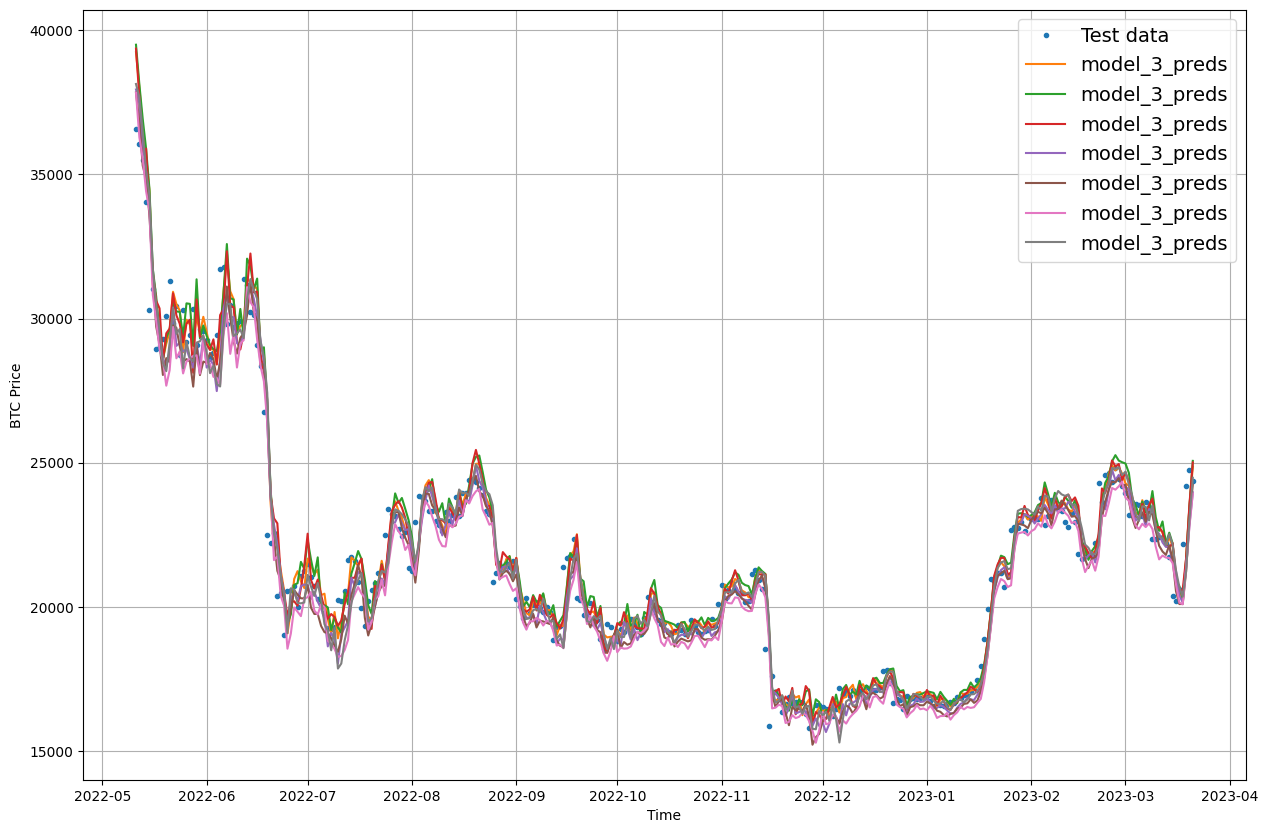

In [66]:
offset=300
plt.figure(figsize=(15,10))

plot_time_series(timesteps=X_test[-len(test_windows):], values=test_labels[:,0], start=offset, label="Test data")
plot_time_series(timesteps=X_test[-len(test_windows):], values=model_3_preds,start=offset,format="-", label="model_3_preds")

Since our predictions were multi-dimensional, the plot predictions also look like stacked every timesteps together.

Let's fix this by aggregating our model's predictions.

**Note**: Aggregating the results of the predictions lead to lose in information from it's original predictions because it was originally predicted for 7 days but if we aggregate it in 1 day then it'll lose the detailed predictions.

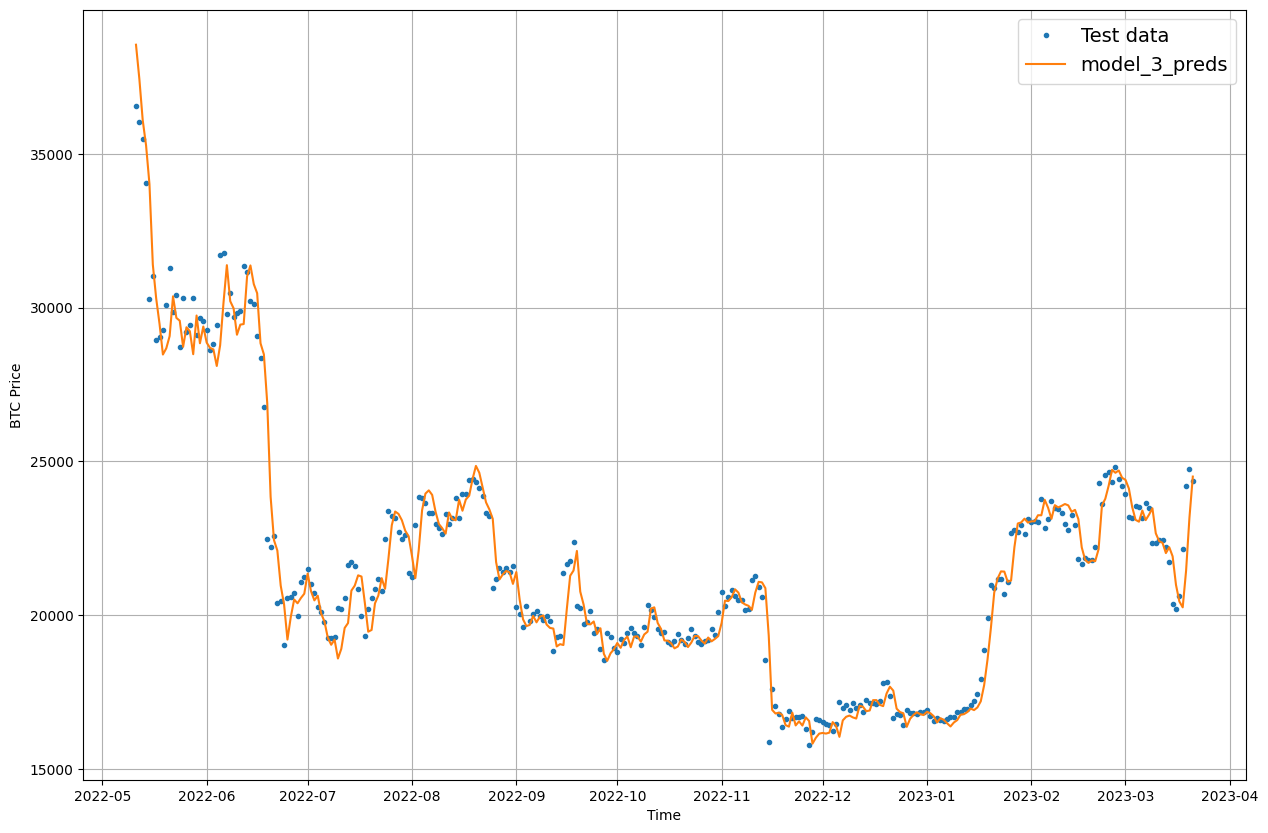

In [67]:
offset = 300
plt.figure(figsize=(15,10))

plot_time_series(timesteps=X_test[-len(test_windows):], values=test_labels[:,0], start=offset, label="Test data")
plot_time_series(timesteps=X_test[-len(test_windows):], values=tf.reduce_mean(model_3_preds, axis=1), start=offset, format="-" ,label="model_3_preds")

## Which of our model is performing best so far ?

So far, we've trained 3 models which use the same architecture but use different data inputs.

Let's compare them with the naive model to see which model is performing the best so far.

<Axes: >

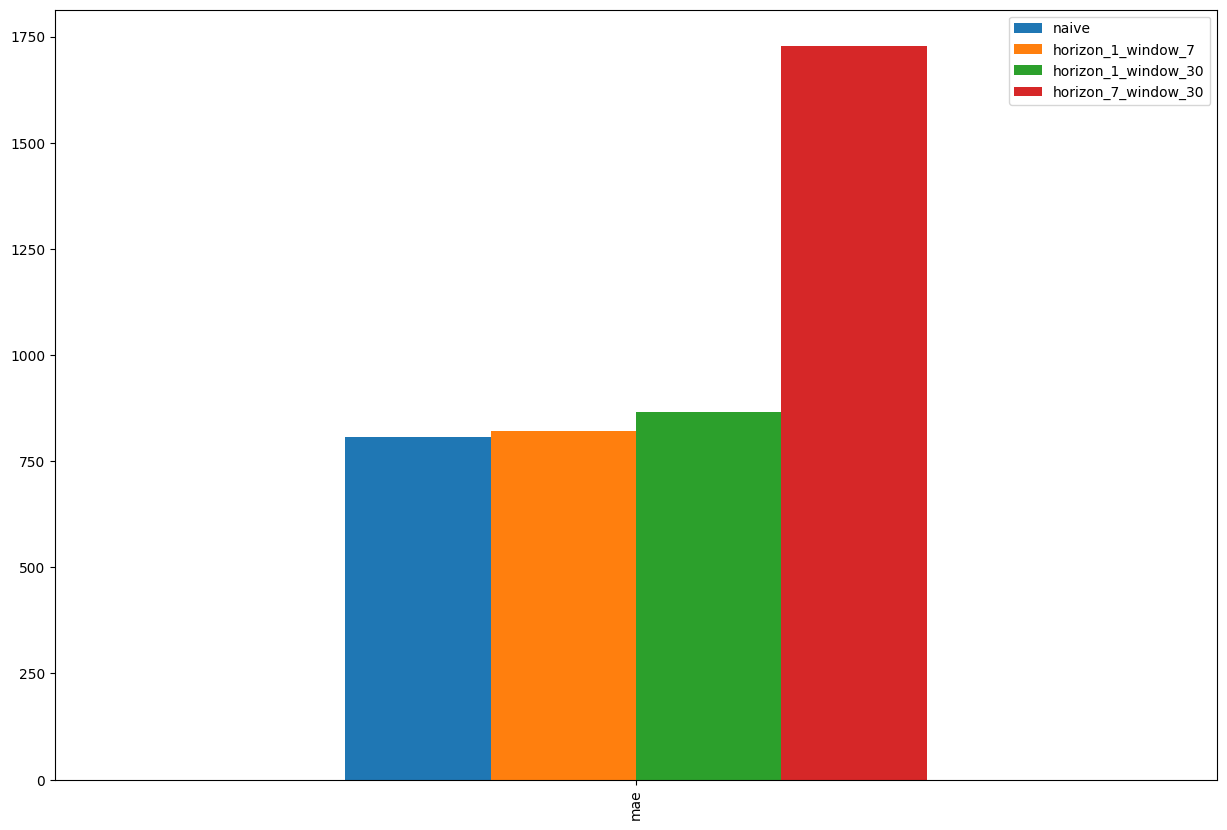

In [68]:
pd.DataFrame({"naive":naive_results['mae'],
              "horizon_1_window_7":model_1_results['mae'],
              'horizon_1_window_30': model_2_results['mae'],
              'horizon_7_window_30': model_3_results['mae']}, index=["mae"]).plot(kind='bar', figsize=(15,10))

Naive model is hard to beat in an open system, but `model_1` with HORIZON 1 and WINDOW SIZE 7 looks to be performing closest. So let's continue our experiments with only these set of horizon and window size.

💡 **Resource**: Due to autocorrelation in the time series data, naive model often performs best because the value of `t` will be closer to `t-1`. Today's value is probably pretty close to yesterday's value. This isn't always the case but when it is, a naive model will often get fairly good results.

Some more about how autocorrelation influences a model's predictions, [How (not) to use Machine learning for Time series forecasting : Avoiding the pitfalls](https://towardsdatascience.com/how-not-to-use-machine-learning-for-time-series-forecasting-avoiding-the-pitfalls-19f9d7adf424)

## Model 4 : Conv1D

We'll be using Conv1D model as it can be used for seq2seq (sequence to sequence) problems.

In our case, the input sequence is the previous 7 days of Bitcoin price data and the output is the next day (in seq2seq terms this is many to one problem).

In [69]:
HORIZON=1
WINDOW_SIZE=7

In [70]:
# make windows for Conv1D model
full_windows, full_labels = make_windows(prices, window_size=WINDOW_SIZE, horizon=HORIZON)
# make train and test split
train_windows, test_windows, train_labels, test_labels = make_train_test_split(full_windows, full_labels)

len(train_windows), len(train_labels), len(test_windows), len(test_labels)

(2480, 2480, 621, 621)

In [71]:
# let's see how our training data looks like
train_windows[0]

array([457.334015, 424.440002, 394.79599 , 408.903992, 398.821014,
       402.152008, 435.790985])

In [72]:
# convert into tensors
x = tf.constant(train_windows[0])
x

<tf.Tensor: shape=(7,), dtype=float64, numpy=
array([457.334015, 424.440002, 394.79599 , 408.903992, 398.821014,
       402.152008, 435.790985])>

Alright, it says the shape is 7 which is the window size. But if we see the doc of [Conv1D layers](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv1D), we need to convert the shape of inputs into `batch size + (timesteps, input_dim)`

In [73]:
# check the shape
x.shape

TensorShape([7])

We need to convert this into (7,1). Let's create a expand dim layer to convert the inputs shape inside the layer.

In [74]:
expand_dim_layer = layers.Lambda(lambda x: tf.expand_dims(x, axis=1))

In [76]:
# Test it with the x 
expand_dim_layer(x)

<tf.Tensor: shape=(7, 1), dtype=float32, numpy=
array([[457.334],
       [424.44 ],
       [394.796],
       [408.904],
       [398.821],
       [402.152],
       [435.791]], dtype=float32)>

In [78]:
# Create the model

tf.random.set_seed(17)

model_4 = tf.keras.Sequential([
    layers.Lambda(lambda x: tf.expand_dims(x, axis=1)),
    layers.Conv1D(128, kernel_size=5, strides=1, padding='causal', activation='relu'),
    layers.Dense(HORIZON)
], name='model_4_conv1D')

# compile the model
model_4.compile(loss='mae',
                optimizer=tf.keras.optimizers.Adam())

# fit the model
model_4.fit(train_windows,
            train_labels,
            epochs=100,
            verbose=1,
            batch_size=128,
            validation_data=(test_windows, test_labels),
            callbacks=[create_model_checkpoint(model_4.name)])

Epoch 1/100
17/20 [========================>.....] - ETA: 0s - loss: 5771.4717 

20/20 [==============================] - 2s 63ms/step - loss: 5283.6660 - val_loss: 2742.0476
Epoch 2/100
 1/20 [>.............................] - ETA: 0s - loss: 954.6404

20/20 [==============================] - 1s 53ms/step - loss: 822.5702 - val_loss: 2356.6609
Epoch 3/100
 1/20 [>.............................] - ETA: 0s - loss: 791.7618

20/20 [==============================] - 1s 38ms/step - loss: 579.5355 - val_loss: 1535.9014
Epoch 4/100
20/20 [==============================] - 0s 4ms/step - loss: 486.6884 - val_loss: 1572.0704
Epoch 5/100
 1/20 [>.............................] - ETA: 0s - loss: 476.5451

20/20 [==============================] - 1s 37ms/step - loss: 471.6534 - val_loss: 1503.7244
Epoch 6/100
20/20 [==============================] - 0s 4ms/step - loss: 465.9580 - val_loss: 1545.3551
Epoch 7/100
 1/20 [>.............................] - ETA: 0s - loss: 370.2386

20/20 [==============================] - 1s 38ms/step - loss: 457.7548 - val_loss: 1475.1145
Epoch 8/100
 1/20 [>.............................] - ETA: 0s - loss: 493.0560

20/20 [==============================] - 1s 48ms/step - loss: 469.8179 - val_loss: 1464.8177
Epoch 9/100
 9/20 [============>.................] - ETA: 0s - loss: 446.3393

20/20 [==============================] - 1s 65ms/step - loss: 448.6242 - val_loss: 1415.7133
Epoch 10/100
20/20 [==============================] - 0s 6ms/step - loss: 439.4915 - val_loss: 1451.3879
Epoch 11/100
 1/20 [>.............................] - ETA: 0s - loss: 403.7174

20/20 [==============================] - 1s 37ms/step - loss: 431.8232 - val_loss: 1389.9728
Epoch 12/100
20/20 [==============================] - 0s 7ms/step - loss: 432.8456 - val_loss: 1478.3887
Epoch 13/100
16/20 [=======================>......] - ETA: 0s - loss: 446.2895

20/20 [==============================] - 1s 60ms/step - loss: 430.9482 - val_loss: 1322.0966
Epoch 14/100
20/20 [==============================] - 0s 7ms/step - loss: 408.1889 - val_loss: 1451.9581
Epoch 15/100
20/20 [==============================] - 0s 7ms/step - loss: 401.2498 - val_loss: 1441.0059
Epoch 16/100
16/20 [=======================>......] - ETA: 0s - loss: 404.6777

20/20 [==============================] - 1s 62ms/step - loss: 395.2199 - val_loss: 1270.4558
Epoch 17/100
20/20 [==============================] - 0s 6ms/step - loss: 384.3987 - val_loss: 1402.5951
Epoch 18/100
17/20 [========================>.....] - ETA: 0s - loss: 392.1773

20/20 [==============================] - 3s 165ms/step - loss: 385.3723 - val_loss: 1210.9509
Epoch 19/100
20/20 [==============================] - 0s 12ms/step - loss: 372.9837 - val_loss: 1342.1761
Epoch 20/100
15/20 [=====================>........] - ETA: 0s - loss: 398.7054

20/20 [==============================] - 1s 59ms/step - loss: 382.9477 - val_loss: 1202.5344
Epoch 21/100
15/20 [=====================>........] - ETA: 0s - loss: 363.1231

20/20 [==============================] - 2s 91ms/step - loss: 358.4254 - val_loss: 1149.2820
Epoch 22/100
20/20 [==============================] - 0s 15ms/step - loss: 350.4351 - val_loss: 1197.1685
Epoch 23/100
20/20 [==============================] - 0s 9ms/step - loss: 349.1576 - val_loss: 1173.2905
Epoch 24/100
 9/20 [============>.................] - ETA: 0s - loss: 361.6205

20/20 [==============================] - 1s 74ms/step - loss: 357.1280 - val_loss: 1133.8784
Epoch 25/100
 1/20 [>.............................] - ETA: 0s - loss: 248.3896

20/20 [==============================] - 1s 61ms/step - loss: 336.1862 - val_loss: 1070.8439
Epoch 26/100
20/20 [==============================] - 0s 5ms/step - loss: 328.2651 - val_loss: 1079.2122
Epoch 27/100
 1/20 [>.............................] - ETA: 0s - loss: 303.3373

20/20 [==============================] - 1s 38ms/step - loss: 327.4117 - val_loss: 1056.3392
Epoch 28/100
 1/20 [>.............................] - ETA: 0s - loss: 257.6699

20/20 [==============================] - 1s 40ms/step - loss: 318.6719 - val_loss: 1021.8342
Epoch 29/100
 1/20 [>.............................] - ETA: 0s - loss: 341.4053

20/20 [==============================] - 1s 38ms/step - loss: 310.1060 - val_loss: 1003.3289
Epoch 30/100
20/20 [==============================] - 0s 4ms/step - loss: 310.4992 - val_loss: 1018.0981
Epoch 31/100
20/20 [==============================] - 0s 4ms/step - loss: 308.5419 - val_loss: 1142.7794
Epoch 32/100
 1/20 [>.............................] - ETA: 0s - loss: 414.2756

20/20 [==============================] - 1s 39ms/step - loss: 306.9787 - val_loss: 987.7402
Epoch 33/100
20/20 [==============================] - 0s 4ms/step - loss: 315.1457 - val_loss: 1128.5026
Epoch 34/100
20/20 [==============================] - 0s 4ms/step - loss: 294.4164 - val_loss: 1000.3705
Epoch 35/100
 1/20 [>.............................] - ETA: 0s - loss: 254.2884

20/20 [==============================] - 1s 38ms/step - loss: 292.6790 - val_loss: 951.0056
Epoch 36/100
20/20 [==============================] - 0s 5ms/step - loss: 289.4188 - val_loss: 988.1822
Epoch 37/100
20/20 [==============================] - ETA: 0s - loss: 290.9828

20/20 [==============================] - 4s 188ms/step - loss: 290.9828 - val_loss: 945.1832
Epoch 38/100
19/20 [===========================>..] - ETA: 0s - loss: 287.8436

20/20 [==============================] - 1s 69ms/step - loss: 288.7430 - val_loss: 937.3263
Epoch 39/100
20/20 [==============================] - 0s 7ms/step - loss: 302.5365 - val_loss: 1067.9343
Epoch 40/100
20/20 [==============================] - 0s 8ms/step - loss: 298.0548 - val_loss: 1161.1904
Epoch 41/100
20/20 [==============================] - 0s 6ms/step - loss: 318.6586 - val_loss: 1181.7664
Epoch 42/100
20/20 [==============================] - 0s 6ms/step - loss: 284.6954 - val_loss: 995.5787
Epoch 43/100
20/20 [==============================] - 0s 10ms/step - loss: 286.4575 - val_loss: 984.6013
Epoch 44/100
20/20 [==============================] - 0s 9ms/step - loss: 298.2778 - val_loss: 1213.5830
Epoch 45/100
18/20 [==========================>...] - ETA: 0s - loss: 302.6601

20/20 [==============================] - 1s 54ms/step - loss: 294.7950 - val_loss: 909.0916
Epoch 46/100
20/20 [==============================] - 0s 7ms/step - loss: 301.6708 - val_loss: 990.8990
Epoch 47/100
20/20 [==============================] - ETA: 0s - loss: 279.9720

20/20 [==============================] - 1s 64ms/step - loss: 279.9720 - val_loss: 902.1994
Epoch 48/100
18/20 [==========================>...] - ETA: 0s - loss: 271.5660

20/20 [==============================] - 2s 104ms/step - loss: 272.7546 - val_loss: 899.9606
Epoch 49/100
16/20 [=======================>......] - ETA: 0s - loss: 271.2088

20/20 [==============================] - 2s 114ms/step - loss: 274.4742 - val_loss: 898.8754
Epoch 50/100
16/20 [=======================>......] - ETA: 0s - loss: 269.3759

20/20 [==============================] - 4s 186ms/step - loss: 269.8143 - val_loss: 896.5425
Epoch 51/100
20/20 [==============================] - 0s 7ms/step - loss: 269.0093 - val_loss: 925.8298
Epoch 52/100
16/20 [=======================>......] - ETA: 0s - loss: 266.0185

20/20 [==============================] - 1s 62ms/step - loss: 269.0694 - val_loss: 892.7249
Epoch 53/100
20/20 [==============================] - 0s 7ms/step - loss: 271.9039 - val_loss: 1003.2613
Epoch 54/100
20/20 [==============================] - 0s 7ms/step - loss: 285.6576 - val_loss: 935.5363
Epoch 55/100
20/20 [==============================] - 0s 7ms/step - loss: 268.7139 - val_loss: 1138.8301
Epoch 56/100
20/20 [==============================] - 0s 5ms/step - loss: 285.7292 - val_loss: 940.1492
Epoch 57/100
 1/20 [>.............................] - ETA: 0s - loss: 270.8393

20/20 [==============================] - 1s 64ms/step - loss: 268.6520 - val_loss: 882.7514
Epoch 58/100
20/20 [==============================] - 0s 7ms/step - loss: 274.8540 - val_loss: 1003.6451
Epoch 59/100
20/20 [==============================] - 0s 6ms/step - loss: 273.2256 - val_loss: 947.1264
Epoch 60/100
20/20 [==============================] - 0s 7ms/step - loss: 270.6469 - val_loss: 939.2679
Epoch 61/100
20/20 [==============================] - 0s 6ms/step - loss: 266.4842 - val_loss: 950.8663
Epoch 62/100
20/20 [==============================] - 0s 7ms/step - loss: 274.7649 - val_loss: 883.3029
Epoch 63/100
20/20 [==============================] - 0s 9ms/step - loss: 266.6854 - val_loss: 883.2906
Epoch 64/100
20/20 [==============================] - 0s 21ms/step - loss: 282.9512 - val_loss: 990.1143
Epoch 65/100
20/20 [==============================] - 0s 17ms/step - loss: 274.9931 - val_loss: 979.6821
Epoch 66/100
20/20 [==============================] - 0s 15ms/step - loss

20/20 [==============================] - 1s 67ms/step - loss: 275.0800 - val_loss: 876.2111
Epoch 74/100
20/20 [==============================] - 0s 8ms/step - loss: 262.0305 - val_loss: 877.7682
Epoch 75/100
20/20 [==============================] - 0s 5ms/step - loss: 265.9478 - val_loss: 945.4128
Epoch 76/100
20/20 [==============================] - 0s 5ms/step - loss: 277.5848 - val_loss: 899.2883
Epoch 77/100
 1/20 [>.............................] - ETA: 0s - loss: 322.7833

20/20 [==============================] - 1s 38ms/step - loss: 270.6809 - val_loss: 865.8711
Epoch 78/100
20/20 [==============================] - 0s 4ms/step - loss: 269.0270 - val_loss: 883.5583
Epoch 79/100
 1/20 [>.............................] - ETA: 0s - loss: 264.7388

20/20 [==============================] - 1s 51ms/step - loss: 259.6353 - val_loss: 862.2709
Epoch 80/100
20/20 [==============================] - 0s 7ms/step - loss: 264.7597 - val_loss: 897.9557
Epoch 81/100
 1/20 [>.............................] - ETA: 0s - loss: 276.6548

20/20 [==============================] - 1s 53ms/step - loss: 263.4870 - val_loss: 859.7836
Epoch 82/100
20/20 [==============================] - 0s 7ms/step - loss: 269.4904 - val_loss: 1152.4458
Epoch 83/100
20/20 [==============================] - 0s 5ms/step - loss: 280.2734 - val_loss: 948.4190
Epoch 84/100
20/20 [==============================] - 0s 6ms/step - loss: 299.9927 - val_loss: 1013.9100
Epoch 85/100
20/20 [==============================] - ETA: 0s - loss: 278.1647

20/20 [==============================] - 1s 43ms/step - loss: 278.1647 - val_loss: 850.7651
Epoch 86/100
20/20 [==============================] - 0s 8ms/step - loss: 256.7177 - val_loss: 921.0403
Epoch 87/100
20/20 [==============================] - 0s 7ms/step - loss: 262.2114 - val_loss: 851.7540
Epoch 88/100
20/20 [==============================] - 0s 6ms/step - loss: 258.0094 - val_loss: 864.6895
Epoch 89/100
15/20 [=====================>........] - ETA: 0s - loss: 258.1440

20/20 [==============================] - 2s 105ms/step - loss: 260.2387 - val_loss: 847.6670
Epoch 90/100
20/20 [==============================] - 0s 9ms/step - loss: 254.3770 - val_loss: 966.6467
Epoch 91/100
20/20 [==============================] - 0s 8ms/step - loss: 258.8898 - val_loss: 855.5143
Epoch 92/100
20/20 [==============================] - 0s 10ms/step - loss: 261.1973 - val_loss: 1009.7702
Epoch 93/100
20/20 [==============================] - 0s 10ms/step - loss: 261.1125 - val_loss: 851.5004
Epoch 94/100
20/20 [==============================] - 0s 14ms/step - loss: 283.1796 - val_loss: 1055.8231
Epoch 95/100
20/20 [==============================] - 0s 15ms/step - loss: 271.8395 - val_loss: 888.4036
Epoch 96/100
20/20 [==============================] - 0s 7ms/step - loss: 256.0404 - val_loss: 930.9680
Epoch 97/100
20/20 [==============================] - 0s 8ms/step - loss: 269.7773 - val_loss: 882.0174
Epoch 98/100
20/20 [==============================] - 0s 8ms/step - l

In [79]:
# check the summary
model_4.summary()

Model: "model_4_conv1D"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lambda_2 (Lambda)           (None, 1, 7)              0         
                                                                 
 conv1d (Conv1D)             (None, 1, 128)            4608      
                                                                 
 dense_6 (Dense)             (None, 1, 1)              129       
                                                                 
Total params: 4,737
Trainable params: 4,737
Non-trainable params: 0
_________________________________________________________________


In [80]:
# evaluate on the last epochs model
model_4.evaluate(test_windows, test_labels)

20/20 [==============================] - 0s 3ms/step - loss: 954.6976


954.6975708007812

In [81]:
# load the best model and evaluate
model_4 = tf.keras.models.load_model("model_experiments/model_4_conv1D")
model_4.evaluate(test_windows, test_labels)

20/20 [==============================] - 0s 4ms/step - loss: 847.6670


847.6669921875

In [83]:
# make some predictions
model_4_preds = make_predictions(model_4, test_windows)

# evaluate the results
model_4_results = evaluate_preds(y_true=tf.squeeze(test_labels),
                                   y_pred=model_4_preds)

model_4_results

20/20 [==============================] - 0s 2ms/step


{'mae': 847.6669,
 'mse': 1597304.6,
 'rmse': 1263.8452,
 'mape': 2.4520912,
 'mase': 1.0000142}

In [84]:
model_1_results

{'mae': 821.655,
 'mse': 1530718.4,
 'rmse': 1237.222,
 'mape': 2.3750055,
 'mase': 1.0000142}

Close enough with `model_1` but not better than it. Let's continue our experiments.

## Model 5 : RNN (LSTM)

We can also use a recurrent neural network to model our sequential time series data.

We're not going to change the data, the data will be same just the model architecture would be different.

In [85]:
tf.random.set_seed(17)

inputs = layers.Input(shape=(WINDOW_SIZE))
x = layers.Lambda(lambda x: tf.expand_dims(x, axis=1))(inputs)
x = layers.LSTM(128, activation='relu', return_sequences=True)(x)
x = layers.LSTM(128, activation='relu')(x)
x = layers.Dense(32, activation='relu')(x)
output = layers.Dense(HORIZON)(x)
model_5 = tf.keras.Model(inputs, output, name="model_5_LSTM")

# compile the model
model_5.compile(loss='mae',
                optimizer='Adam')

# fit the model
model_5.fit(train_windows,
            train_labels,
            epochs=100,
            batch_size=128,
            verbose=0,
            validation_data=(test_windows, test_labels),
            callbacks=[create_model_checkpoint(model_5.name)])

In [86]:
# check the summary
model_5.summary()

Model: "model_5_LSTM"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 7)]               0         
                                                                 
 lambda_3 (Lambda)           (None, 1, 7)              0         
                                                                 
 lstm (LSTM)                 (None, 1, 128)            69632     
                                                                 
 lstm_1 (LSTM)               (None, 128)               131584    
                                                                 
 dense_7 (Dense)             (None, 32)                4128      
                                                                 
 dense_8 (Dense)             (None, 1)                 33        
                                                                 
Total params: 205,377
Trainable params: 205,377
Non-tr

In [87]:
# evaluate on last epoch
model_5.evaluate(test_windows, test_labels)

20/20 [==============================] - 0s 3ms/step - loss: 896.3133


896.3132934570312

In [88]:
# load the best model and evaluate
model_5 = tf.keras.models.load_model("model_experiments/model_5_LSTM/")
model_5.evaluate(test_windows, test_labels)

20/20 [==============================] - 0s 3ms/step - loss: 871.6198


871.6197509765625

In [89]:
# make predictions and check pred results
model_5_preds = make_predictions(model_5, test_windows)

model_5_results = evaluate_preds(tf.squeeze(test_labels), model_5_preds)

model_5_results

20/20 [==============================] - 0s 3ms/step


{'mae': 871.6199,
 'mse': 1689080.0,
 'rmse': 1299.6461,
 'mape': 2.522435,
 'mase': 1.0000142}